# K-means and Gaussian Mixture Models

*By Yuan-Sen Ting, April 2025, for ASTRON 5550*

In this tutorial, we'll explore two fundamental clustering algorithms: K-means and Gaussian Mixture Models (GMMs). Clustering is an unsupervised learning technique that groups similar data points together based on their features. These methods are powerful tools for discovering hidden structure in unlabeled data.

## Introduction to Clustering Methods

### K-means Clustering
K-means is one of the most widely used clustering algorithms due to its simplicity and efficiency. It partitions data into K non-overlapping clusters by:
1. Assigning each data point to the nearest centroid
2. Updating centroids based on the mean of assigned points
3. Repeating until convergence

K-means has several key characteristics:
- It creates spherical clusters of similar sizes
- It makes "hard" assignments (each point belongs to exactly one cluster)
- It's sensitive to initialization and outliers
- It requires specifying the number of clusters (K) in advance

### Gaussian Mixture Models (GMMs)
GMMs provide a more flexible probabilistic approach to clustering. Instead of making hard assignments, GMMs model the data as being generated from a mixture of several Gaussian distributions. The key advantages of GMMs include:
- They allow for clusters with different shapes and sizes
- They make "soft" assignments (probabilities of belonging to each cluster)
- They provide uncertainty measures for cluster assignments
- They can better capture complex cluster geometries

Rather than using pre-packaged implementations, we'll build these methods from scratch to develop a deeper understanding of how they work. We'll apply these methods to analyze stellar data from the Sculptor dwarf spheroidal galaxy, demonstrating how clustering techniques can reveal underlying structure in astronomical data.

## Astrophysical Background: Bursty Star Formation in Dwarf Galaxies

This tutorial builds on research presented in "Quantifying Bursty Star Formation in Dwarf Galaxies" ([Ting & Ji, 2025](https://ui.adsabs.harvard.edu/abs/2025OJAp....8E...7T/abstract)), which demonstrated that episodic star formation can leave distinct imprints on a galaxy's chemical evolution. When star formation occurs in bursts followed by quiescent periods, we expect to see discontinuous tracks in a galaxy's chemical abundance plane.

### Chemical Abundances and Their Significance

The two key chemical abundance ratios we'll focus on are:

- **[Fe/H]** (iron-to-hydrogen ratio): A measure of overall metallicity, representing the logarithmic ratio of iron to hydrogen abundance relative to the solar value. Since iron accumulates in a galaxy over time, [Fe/H] broadly tracks the progression of star formation.

- **[Mg/Fe]** (magnesium-to-iron ratio): Measures the relative abundance of α-elements (like magnesium) compared to iron. This ratio provides information about the relative contributions of different types of supernovae to chemical enrichment.

### Why Clustering Methods Are Useful

The key insight from Ting & Ji (2025) is that bursty star formation leads to a distinctive pattern: discrete "clumps" or multimodality in the [Mg/Fe]-[Fe/H] plane. This occurs because:

1. During active star formation, core-collapse supernovae from massive stars enrich the interstellar medium primarily with α-elements (like Mg) and some iron
2. During quiescent periods, Type Ia supernovae (from white dwarf systems) continue to produce iron but little magnesium
3. When star formation resumes, new stars form with enhanced iron but depleted [Mg/Fe]

These distinct populations appear as separate clusters in chemical abundance space. Identifying these clusters can reveal the star formation history of a galaxy, potentially showing evidence of episodic starbursts separated by hundreds of millions of years.

By applying clustering algorithms, we can objectively identify and characterize these different stellar populations without imposing prior assumptions about their number or properties.

## Prerequisites
 
Before diving into this tutorial, you should be familiar with the material in the lecture notes:
- Theoretical foundations of K-means and Gaussian Mixture Models (GMMs)
- The Expectation-Maximization (EM) algorithm
- Information criteria for model selection (AIC, BIC)
- Maximum likelihood estimation principles

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import multivariate_normal
import matplotlib.cm as cm  # For color maps in visualization

# Set plot styling
plt.rcParams['figure.figsize'] = (10, 6)

# Set a random seed for reproducibility
np.random.seed(42)

## Loading and Exploring the Dataset

For this tutorial, we'll use spectroscopic data from the Sculptor dwarf spheroidal galaxy. Sculptor is a satellite galaxy of the Milky Way, located about 290,000 light-years away. It's an excellent case study for understanding episodic star formation in dwarf galaxies.

Looking at the chemical abundance data, we expect to see evidence of distinct stellar populations that formed during different episodes of star formation. If the bursty star formation hypothesis is correct, we should observe clusters in the [Fe/H]-[Mg/Fe] plane.

Let's load the dataset and visualize the chemical abundance distributions:

Successfully loaded dataset with 143 stars


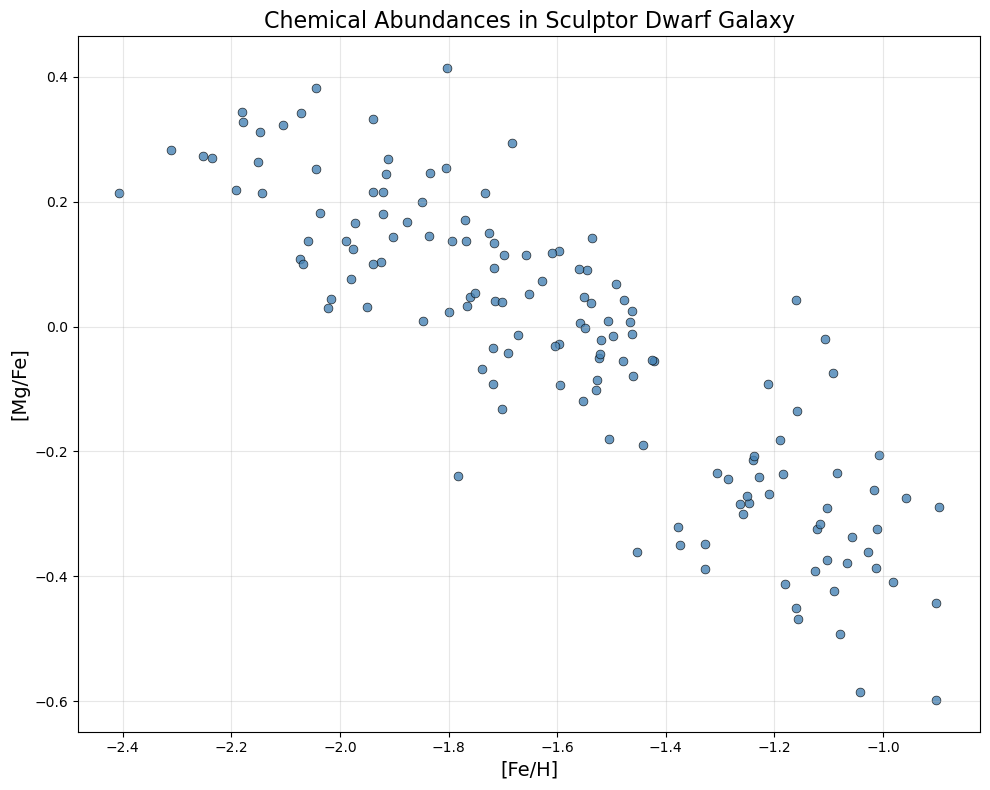

In [35]:
# Load the Sculptor dwarf galaxy data
data = pd.read_csv("dataset_apogee_sculptor.csv")
print("Successfully loaded dataset with", len(data), "stars")
    
# Clean data by dropping NaN values
# data = data.dropna(subset=["FE_H", "MG_FE"])

# Extract data as NumPy array for our algorithms
X = data[['FE_H', 'MG_FE']].values

# Simple visualization of the chemical abundance data
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], alpha=0.8, s=40, c='steelblue', edgecolor='k', linewidth=0.5)
plt.xlabel('[Fe/H]', fontsize=14)
plt.ylabel('[Mg/Fe]', fontsize=14)
plt.title('Chemical Abundances in Sculptor Dwarf Galaxy', fontsize=16)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Part 1: K-means Clustering from Scratch

K-means is one of the simplest and most widely used clustering algorithms. It aims to partition n observations into k clusters, where each observation belongs to the cluster with the nearest mean (centroid).

### The K-means Algorithm

The basic steps of K-means are:

1. **Initialization**: Select k initial centroids
2. **Assignment**: Assign each data point to the nearest centroid
3. **Update**: Recalculate centroids as the mean of all points in each cluster
4. **Repeat**: Iterate steps 2-3 until convergence

Before applying K-means, it's often helpful to standardize our data to ensure features with larger scales don't dominate the distance calculations. Let's implement a standardization function and apply it to our data:

Original data range:
[Fe/H]: -2.41 to -0.90
[Mg/Fe]: -0.60 to 0.41

Standardized data range:
[Fe/H]: -2.28 to 1.87
[Mg/Fe]: -2.45 to 1.94


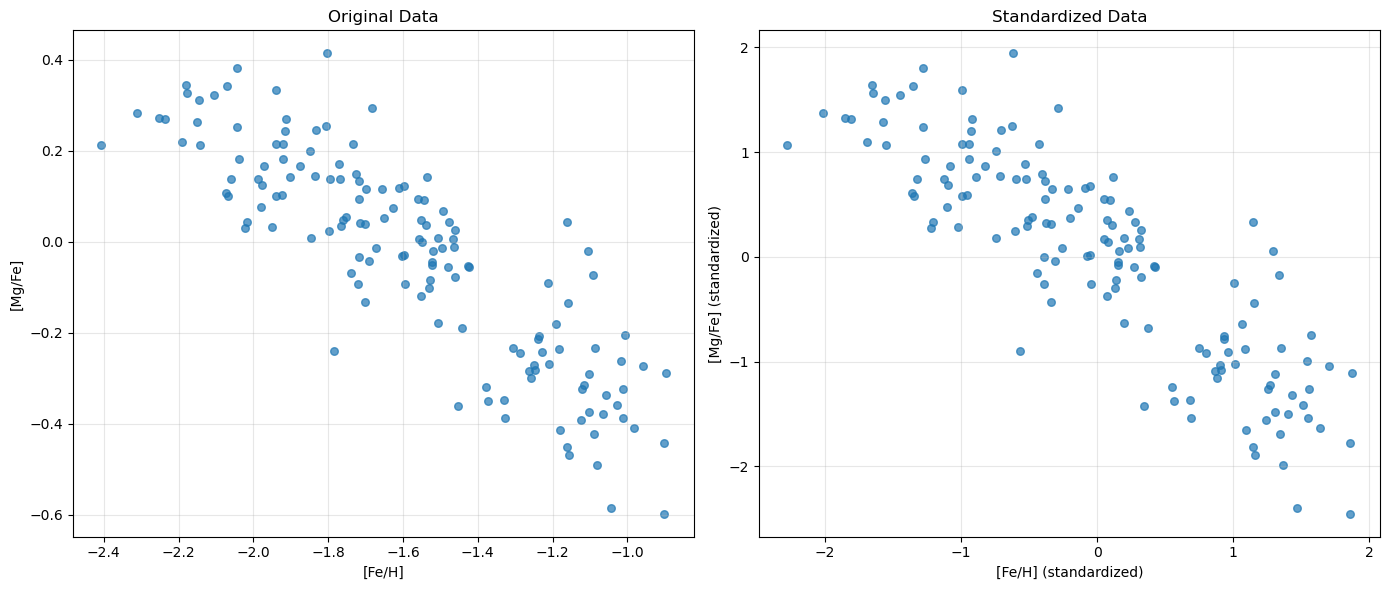

In [36]:
def standardize(X):
    """Standardize features to have zero mean and unit variance"""
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    return (X - mean) / std, mean, std

# Standardize our data (important for K-means)
X_std, mean_X, std_X = standardize(X)

print("Original data range:")
print(f"[Fe/H]: {np.min(X[:, 0]):.2f} to {np.max(X[:, 0]):.2f}")
print(f"[Mg/Fe]: {np.min(X[:, 1]):.2f} to {np.max(X[:, 1]):.2f}")

print("\nStandardized data range:")
print(f"[Fe/H]: {np.min(X_std[:, 0]):.2f} to {np.max(X_std[:, 0]):.2f}")
print(f"[Mg/Fe]: {np.min(X_std[:, 1]):.2f} to {np.max(X_std[:, 1]):.2f}")

# Visualize original vs standardized data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Original data
ax1.scatter(X[:, 0], X[:, 1], alpha=0.7, s=30)
ax1.set_xlabel('[Fe/H]')
ax1.set_ylabel('[Mg/Fe]')
ax1.set_title('Original Data')
ax1.grid(True, alpha=0.3)

# Standardized data
ax2.scatter(X_std[:, 0], X_std[:, 1], alpha=0.7, s=30)
ax2.set_xlabel('[Fe/H] (standardized)')
ax2.set_ylabel('[Mg/Fe] (standardized)')
ax2.set_title('Standardized Data')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Step 1: Initialization Methods

The choice of initial centroids can significantly affect the convergence and quality of K-means clustering. Let's implement two initialization methods:

1. **Random Initialization**: Simply select k data points at random as initial centroids
2. **K-means++**: A smarter initialization method that chooses centroids that are far apart from each other

The K-means++ algorithm works by:
1. Choosing the first centroid randomly from the data points
2. For subsequent centroids, selecting points with probability proportional to their squared distance from the nearest existing centroid

This tends to select initial centroids that are spread out across the data, leading to better convergence and more stable results. In the visualization below, notice how K-means++ tends to spread the initial centroids more evenly across the data distribution, while random initialization may place centroids close together, potentially leading to suboptimal clustering.

Random initial centroids (standardized):
[[-0.74038401  0.18312468]
 [-1.32421202  0.74224464]
 [-0.62048347  1.9413103 ]
 [-0.08890556  0.6587543 ]]

K-means++ initial centroids (standardized):
[[ 0.41792236 -0.09038834]
 [ 1.15850133 -1.88973795]
 [-1.64981405  1.56378159]
 [-0.47858243  0.37604889]]


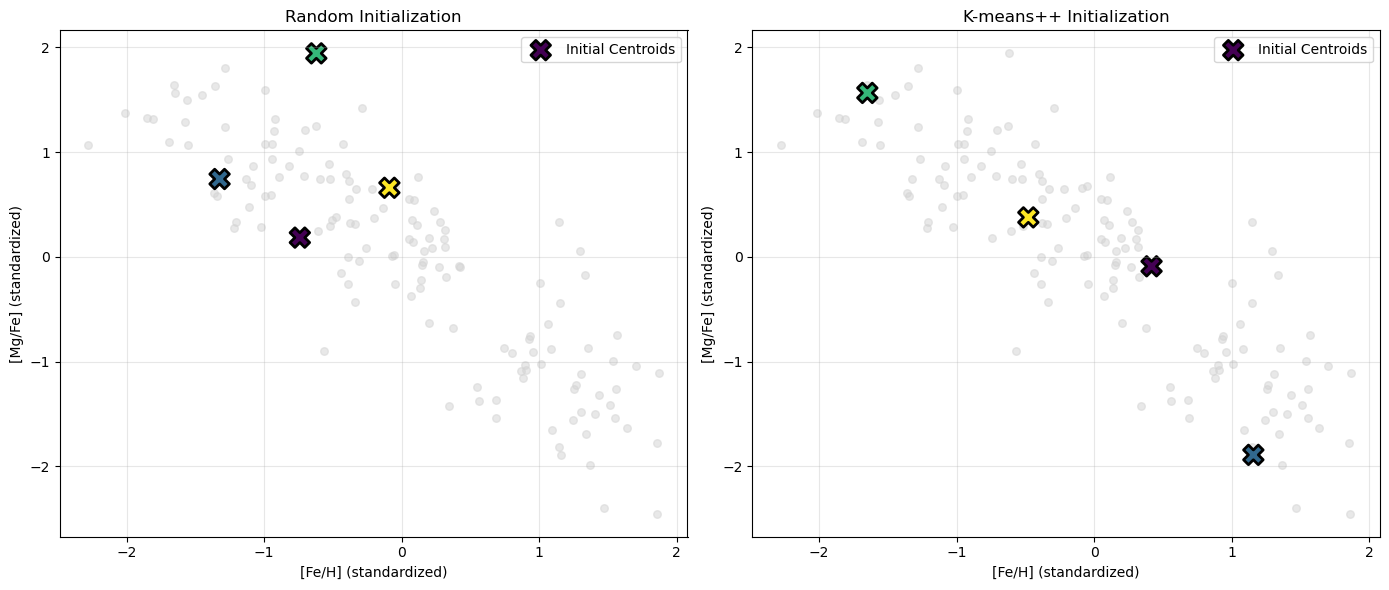

In [37]:
def init_random(X, k, random_state=None):
    """
    Initialize k centroids randomly from data points
    
    Parameters:
    -----------
    X : array, shape (n_samples, n_features)
        The input data
    k : int
        The number of clusters
    random_state : int or None
        Random seed for reproducibility
    
    Returns:
    --------
    centroids : array, shape (k, n_features)
        The initial centroids
    """
    if random_state is not None:
        np.random.seed(random_state)
        
    # Randomly select k data points as centroids
    indices = np.random.choice(X.shape[0], k, replace=False)
    return X[indices].copy()

def init_kmeans_plus_plus(X, k, random_state=None):
    """
    Initialize centroids using the K-means++ method
    
    Parameters:
    -----------
    X : array, shape (n_samples, n_features)
        The input data
    k : int
        The number of clusters
    random_state : int or None
        Random seed for reproducibility
    
    Returns:
    --------
    centroids : array, shape (k, n_features)
        The initial centroids
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    # Number of samples and features
    n_samples, n_features = X.shape
    
    # Initialize list to store centroids
    centroids = np.zeros((k, n_features))
    
    # Choose first centroid randomly
    first_centroid_idx = np.random.choice(n_samples)
    centroids[0] = X[first_centroid_idx]
    
    # Choose remaining centroids
    for c in range(1, k):
        # Compute squared distances to nearest existing centroid
        min_distances = np.zeros(n_samples)
        
        for i in range(n_samples):
            # Find distance to closest centroid
            min_dist = float('inf')
            for j in range(c):
                dist = np.sum((X[i] - centroids[j])**2)
                if dist < min_dist:
                    min_dist = dist
            min_distances[i] = min_dist
        
        # Choose next centroid with probability proportional to squared distance
        probabilities = min_distances / np.sum(min_distances)
        next_centroid_idx = np.random.choice(n_samples, p=probabilities)
        centroids[c] = X[next_centroid_idx]
    
    return centroids

# Test both initialization methods with k=4
random_centroids = init_random(X_std, k=4, random_state=42)
kmeans_pp_centroids = init_kmeans_plus_plus(X_std, k=4, random_state=42)

print("Random initial centroids (standardized):")
print(random_centroids)
print("\nK-means++ initial centroids (standardized):")
print(kmeans_pp_centroids)

# Visualize both initialization methods
plt.figure(figsize=(14, 6))

# Plot for random initialization
plt.subplot(1, 2, 1)
plt.scatter(X_std[:, 0], X_std[:, 1], alpha=0.5, s=30, c='lightgray')
plt.scatter(random_centroids[:, 0], random_centroids[:, 1], 
           c=np.arange(4), s=200, marker='X', cmap='viridis', 
           edgecolor='k', linewidth=2, label='Initial Centroids')
plt.xlabel('[Fe/H] (standardized)')
plt.ylabel('[Mg/Fe] (standardized)')
plt.title('Random Initialization')
plt.grid(True, alpha=0.3)
plt.legend()

# Plot for k-means++ initialization
plt.subplot(1, 2, 2)
plt.scatter(X_std[:, 0], X_std[:, 1], alpha=0.5, s=30, c='lightgray')
plt.scatter(kmeans_pp_centroids[:, 0], kmeans_pp_centroids[:, 1], 
           c=np.arange(4), s=200, marker='X', cmap='viridis', 
           edgecolor='k', linewidth=2, label='Initial Centroids')
plt.xlabel('[Fe/H] (standardized)')
plt.ylabel('[Mg/Fe] (standardized)')
plt.title('K-means++ Initialization')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

### Step 2: E-step (Expectation Step) - Assigning Points to Clusters

Once we have initial centroids, the next step in K-means is the Expectation step (E-step), where we assign each data point to the nearest centroid. For each data point, we:

1. Calculate the distance to each centroid
2. Assign the point to the cluster with the closest centroid

This is called the E-step because we're calculating the expected cluster membership of each point given the current centroids. Since we're using Euclidean distance, we can simplify the calculations by using squared distances (which preserves relative ordering and avoids unnecessary square root operations).

After the assignment, we'll have a cluster label for each data point, telling us which of the k clusters it belongs to. Let's implement and visualize this E-step:

Cluster assignments after E-step:
Cluster 0: 37 samples
Cluster 1: 35 samples
Cluster 2: 21 samples
Cluster 3: 50 samples


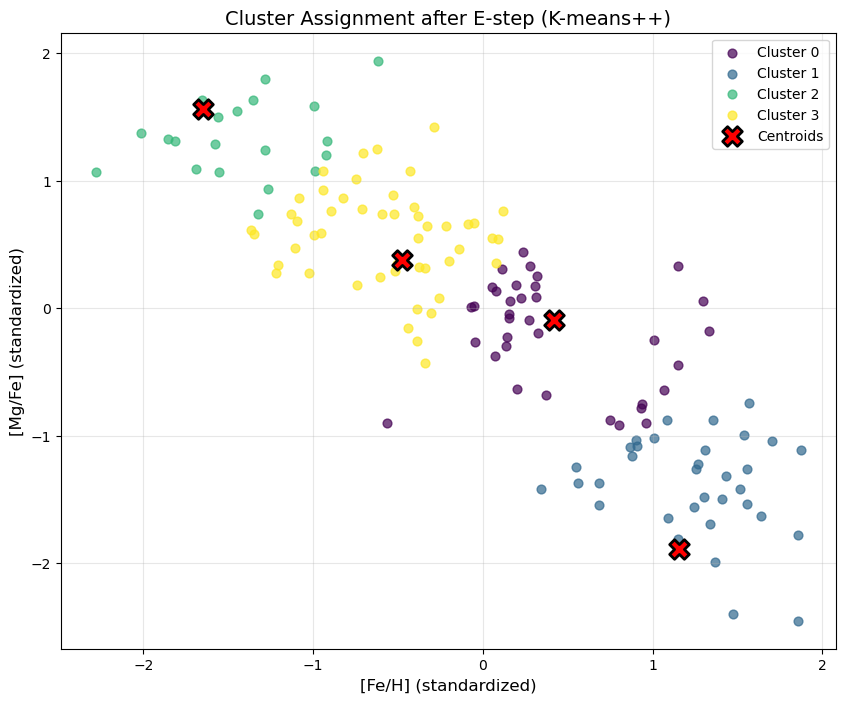

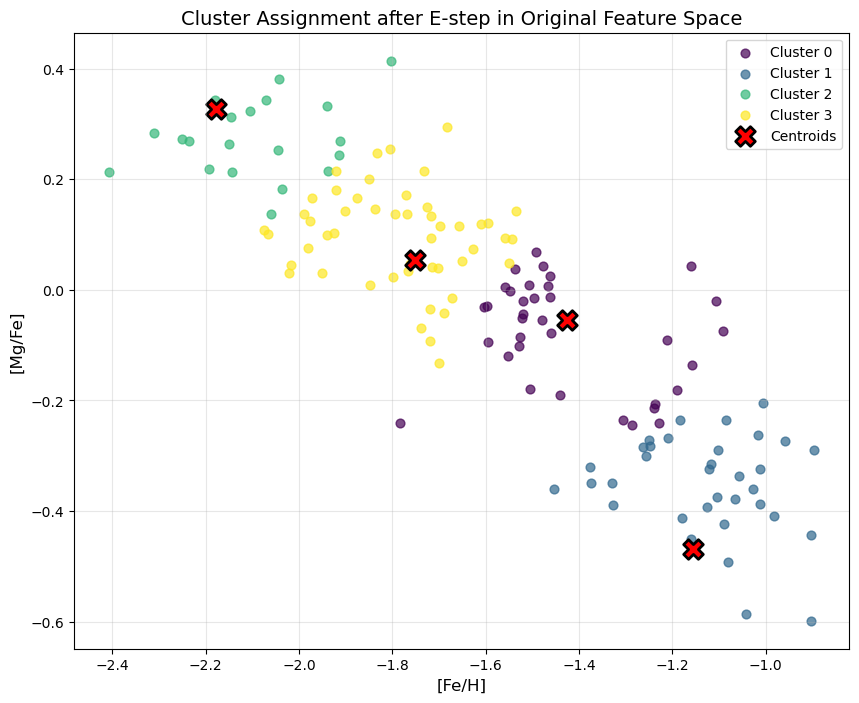

In [38]:
def assign_clusters(X, centroids):
    """
    E-step: Assign each data point to the nearest centroid
    
    Parameters:
    -----------
    X : array, shape (n_samples, n_features)
        The input data
    centroids : array, shape (k, n_features)
        The current centroids
    
    Returns:
    --------
    labels : array, shape (n_samples,)
        The cluster assignments for each data point
    """
    n_samples = X.shape[0]
    k = centroids.shape[0]
    
    # Initialize array to store distances to each centroid
    distances = np.zeros((n_samples, k))
    
    # Calculate squared Euclidean distance to each centroid
    for i in range(k):
        distances[:, i] = np.sum((X - centroids[i])**2, axis=1)
    
    # Assign each point to the nearest centroid
    labels = np.argmin(distances, axis=1)
    
    return labels

# Test E-step with our K-means++ centroids for k=4
labels = assign_clusters(X_std, kmeans_pp_centroids)

# Count samples in each cluster
unique_labels, counts = np.unique(labels, return_counts=True)
print("Cluster assignments after E-step:")
for label, count in zip(unique_labels, counts):
    print(f"Cluster {label}: {count} samples")

# Visualize the initial cluster assignment
plt.figure(figsize=(10, 8))

# Create a color map for 4 clusters
colors = plt.cm.viridis(np.linspace(0, 1, 4))

# Plot each cluster with different color
for i in range(4):
    cluster_points = X_std[labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
               color=colors[i], alpha=0.7, s=40, label=f'Cluster {i}')

# Plot centroids
plt.scatter(kmeans_pp_centroids[:, 0], kmeans_pp_centroids[:, 1], 
           c='red', s=200, marker='X', label='Centroids', edgecolor='black', linewidth=2)

plt.xlabel('[Fe/H] (standardized)', fontsize=12)
plt.ylabel('[Mg/Fe] (standardized)', fontsize=12)
plt.title('Cluster Assignment after E-step (K-means++)', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

# Visualize the initial cluster assignment in original feature space
plt.figure(figsize=(10, 8))

# Convert standardized centroids to original scale
centroids_orig = kmeans_pp_centroids * std_X + mean_X

# Plot each cluster with different color
for i in range(4):
    cluster_points = X[labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
               color=colors[i], alpha=0.7, s=40, label=f'Cluster {i}')

# Plot centroids
plt.scatter(centroids_orig[:, 0], centroids_orig[:, 1], 
           c='red', s=200, marker='X', label='Centroids', edgecolor='black', linewidth=2)

plt.xlabel('[Fe/H]', fontsize=12)
plt.ylabel('[Mg/Fe]', fontsize=12)
plt.title('Cluster Assignment after E-step in Original Feature Space', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

### Step 3: M-step (Maximization Step) - Updating Centroids

After assigning each data point to a cluster, the next step is to update the centroids to better fit the assigned points. This is called the Maximization step (M-step) because we're maximizing the fit of each centroid to its assigned points.

For each cluster, we:
1. Select all points assigned to that cluster
2. Compute the mean of those points
3. Set the new centroid to that mean

This process ensures that centroids move to the center of their assigned points, minimizing the within-cluster distance. After the M-step, centroids will have moved from their initial positions, often significantly in the first few iterations.

Let's implement the M-step and visualize how the centroids move:

Updated centroids (standardized):
[[ 0.42127431 -0.1912612 ]
 [ 1.23700711 -1.39768945]
 [-1.43139727  1.34481714]
 [-0.57646111  0.5550927 ]]


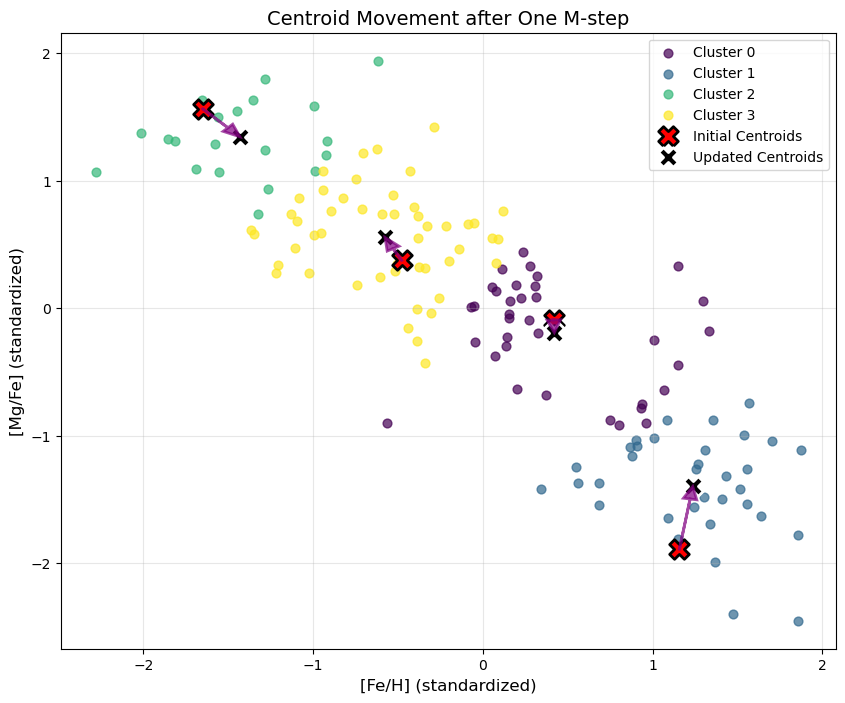


Centroid movement distances:
Centroid 0 moved by: 0.1009 units
Centroid 1 moved by: 0.4983 units
Centroid 2 moved by: 0.3093 units
Centroid 3 moved by: 0.2041 units


In [39]:
def update_centroids(X, labels, k):
    """
    M-step: Update centroids based on current cluster assignments
    
    Parameters:
    -----------
    X : array, shape (n_samples, n_features)
        The input data
    labels : array, shape (n_samples,)
        The cluster assignments
    k : int
        The number of clusters
    
    Returns:
    --------
    centroids : array, shape (k, n_features)
        The updated centroids
    """
    n_features = X.shape[1]
    centroids = np.zeros((k, n_features))
    
    for i in range(k):
        # Select points in this cluster
        cluster_points = X[labels == i]
        
        # Handle empty clusters (should be rare)
        if len(cluster_points) > 0:
            centroids[i] = np.mean(cluster_points, axis=0)
    
    return centroids

# Update centroids based on our initial assignment
updated_centroids = update_centroids(X_std, labels, k=4)
print("Updated centroids (standardized):")
print(updated_centroids)

# Visualize centroid movement
plt.figure(figsize=(10, 8))

# Plot data points by cluster
for i in range(4):
    cluster_points = X_std[labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
               color=colors[i], alpha=0.7, s=40, label=f'Cluster {i}')

# Plot old centroids
plt.scatter(kmeans_pp_centroids[:, 0], kmeans_pp_centroids[:, 1], 
           c='red', s=200, marker='X', label='Initial Centroids', 
           edgecolor='black', linewidth=2)

# Plot updated centroids
plt.scatter(updated_centroids[:, 0], updated_centroids[:, 1], 
           c='black', s=200, marker='X', label='Updated Centroids', 
           edgecolor='white', linewidth=2)

# Draw arrows showing centroid movement
for i in range(4):
    plt.arrow(kmeans_pp_centroids[i, 0], kmeans_pp_centroids[i, 1],
             updated_centroids[i, 0] - kmeans_pp_centroids[i, 0],
             updated_centroids[i, 1] - kmeans_pp_centroids[i, 1],
             head_width=0.08, head_length=0.1, fc='purple', ec='purple', 
             length_includes_head=True, alpha=0.7, linewidth=2)

plt.xlabel('[Fe/H] (standardized)', fontsize=12)
plt.ylabel('[Mg/Fe] (standardized)', fontsize=12)
plt.title('Centroid Movement after One M-step', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

# Calculate how much each centroid moved
centroid_movement = np.sqrt(np.sum((updated_centroids - kmeans_pp_centroids)**2, axis=1))
print("\nCentroid movement distances:")
for i, distance in enumerate(centroid_movement):
    print(f"Centroid {i} moved by: {distance:.4f} units")

### Step 4: Putting It All Together - The Complete K-means Algorithm

Now we'll combine all these steps to create a complete K-means clustering algorithm:

1. Initialize centroids (using either random or K-means++ method)
2. Repeat until convergence:
   - **E-step**: Assign each point to the nearest centroid
   - **M-step**: Update centroids based on the assigned points
   - Check for convergence (minimal movement of centroids)

We'll also track the algorithm's convergence by measuring the "inertia" (sum of squared distances from each point to its assigned centroid) at each iteration. A lower inertia indicates a better fit, and the algorithm converges when the inertia stops decreasing significantly.

Let's implement the full K-means algorithm and apply it to our stellar data:

K-means with Random Initialization:
Iterations: 10
Inertia: 38.6039

K-means with K-means++ Initialization:
Iterations: 5
Inertia: 38.6039


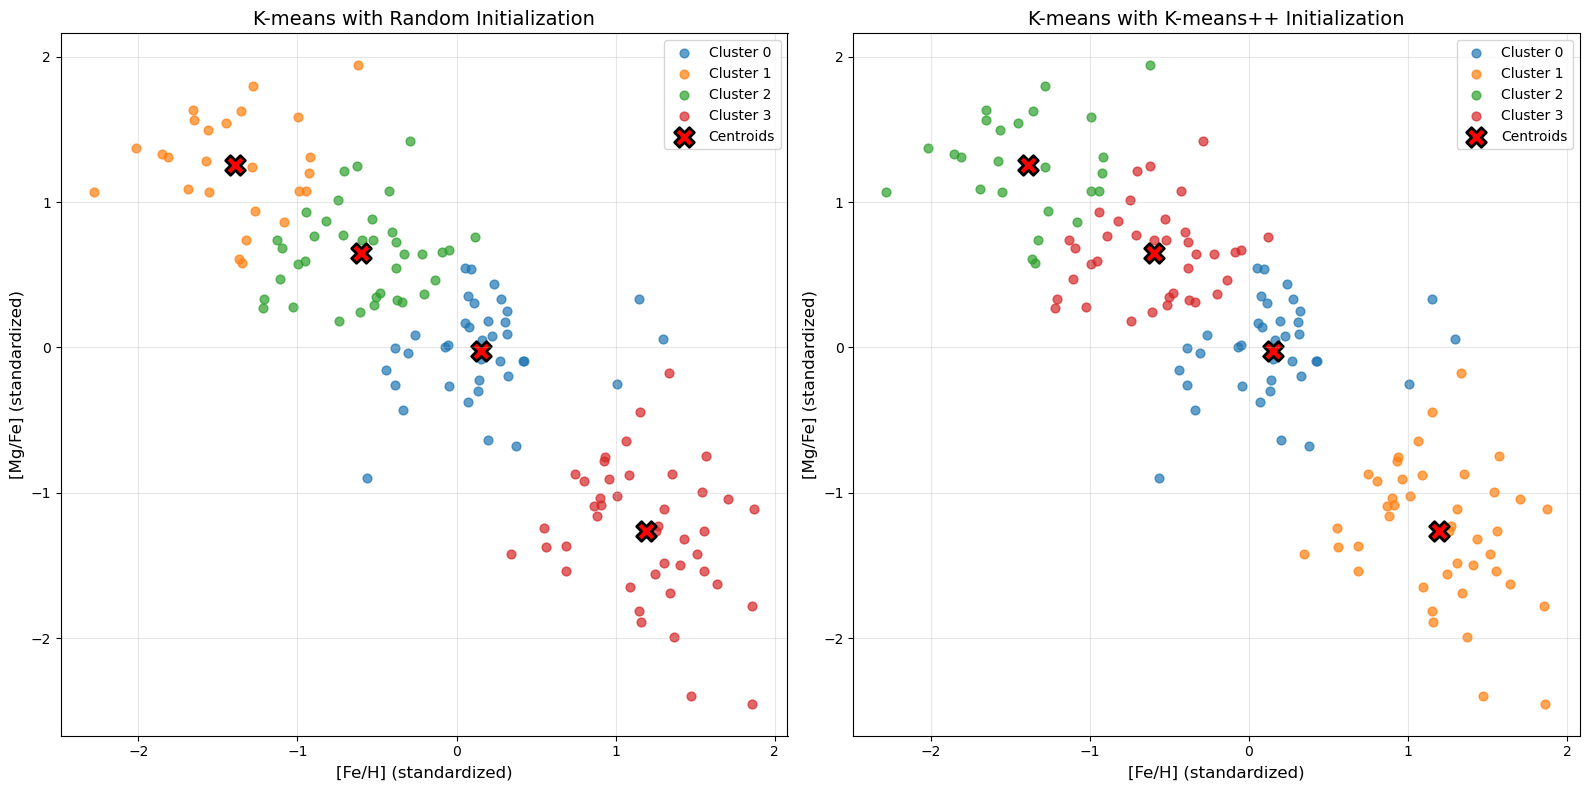

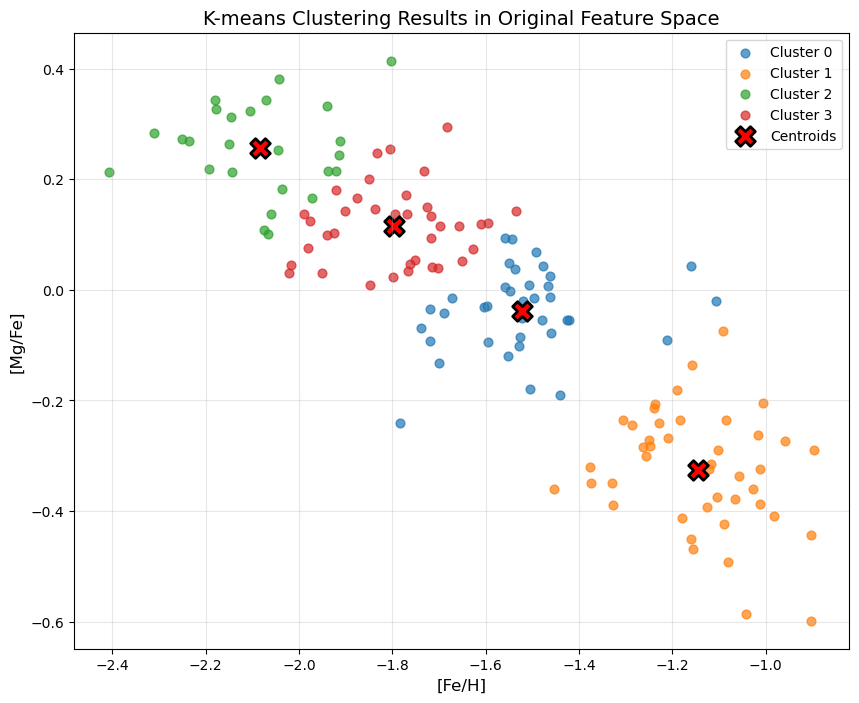

In [40]:
def kmeans(X, k, max_iter=100, tol=1e-4, init_method='random', random_state=None):
    """
    K-means clustering algorithm
    
    Parameters:
    -----------
    X : array, shape (n_samples, n_features)
        The input data
    k : int
        The number of clusters
    max_iter : int
        Maximum number of iterations
    tol : float
        Convergence tolerance (change in centroids)
    init_method : str, 'random' or 'kmeans++'
        Method for initializing centroids
    random_state : int or None
        Random seed for reproducibility
    
    Returns:
    --------
    centroids : array, shape (k, n_features)
        The final centroids
    labels : array, shape (n_samples,)
        The final cluster assignments
    inertia : float
        Sum of squared distances to closest centroid
    n_iter : int
        Number of iterations run
    history : dict
        Dictionary containing centroid history for visualization
    """
    # Initialize centroids
    if init_method == 'random':
        centroids = init_random(X, k, random_state)
    elif init_method == 'kmeans++':
        centroids = init_kmeans_plus_plus(X, k, random_state)
    else:
        raise ValueError("init_method must be 'random' or 'kmeans++'")
    
    # Initialize history for visualization
    history = {
        'centroids': [centroids.copy()],
        'inertia': []
    }
    
    # Iterative optimization
    n_iter = 0
    for i in range(max_iter):
        # E-step: Assign clusters
        labels = assign_clusters(X, centroids)
        
        # M-step: Update centroids
        new_centroids = update_centroids(X, labels, k)
        
        # Calculate inertia (sum of squared distances to closest centroid)
        inertia = 0
        for j in range(k):
            cluster_points = X[labels == j]
            if len(cluster_points) > 0:
                inertia += np.sum((cluster_points - new_centroids[j])**2)
        
        history['inertia'].append(inertia)
        
        # Check for convergence
        centroid_shift = np.sum((new_centroids - centroids)**2)
        centroids = new_centroids
        history['centroids'].append(centroids.copy())
        
        n_iter += 1
        
        if centroid_shift < tol:
            break
    
    # Final assignment
    labels = assign_clusters(X, centroids)
    
    # Calculate final inertia
    inertia = 0
    for j in range(k):
        cluster_points = X[labels == j]
        if len(cluster_points) > 0:
            inertia += np.sum((cluster_points - centroids[j])**2)
    
    return centroids, labels, inertia, n_iter, history

# Run K-means with k=4 using both initialization methods
random_centroids, random_labels, random_inertia, random_iters, random_history = kmeans(
    X_std, k=4, init_method='random', random_state=42)

kmpp_centroids, kmpp_labels, kmpp_inertia, kmpp_iters, kmpp_history = kmeans(
    X_std, k=4, init_method='kmeans++', random_state=42)

# Print results for comparison
print("K-means with Random Initialization:")
print(f"Iterations: {random_iters}")
print(f"Inertia: {random_inertia:.4f}")

print("\nK-means with K-means++ Initialization:")
print(f"Iterations: {kmpp_iters}")
print(f"Inertia: {kmpp_inertia:.4f}")

# Plot final clustering results for both methods
plt.figure(figsize=(16, 8))

# Random initialization results
plt.subplot(1, 2, 1)
for i in range(4):
    cluster_points = X_std[random_labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
               alpha=0.7, s=40, label=f'Cluster {i}')

plt.scatter(random_centroids[:, 0], random_centroids[:, 1], 
           c='red', s=200, marker='X', label='Centroids', edgecolor='black', linewidth=2)
plt.xlabel('[Fe/H] (standardized)', fontsize=12)
plt.ylabel('[Mg/Fe] (standardized)', fontsize=12)
plt.title('K-means with Random Initialization', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# K-means++ initialization results
plt.subplot(1, 2, 2)
for i in range(4):
    cluster_points = X_std[kmpp_labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
               alpha=0.7, s=40, label=f'Cluster {i}')

plt.scatter(kmpp_centroids[:, 0], kmpp_centroids[:, 1], 
           c='red', s=200, marker='X', label='Centroids', edgecolor='black', linewidth=2)
plt.xlabel('[Fe/H] (standardized)', fontsize=12)
plt.ylabel('[Mg/Fe] (standardized)', fontsize=12)
plt.title('K-means with K-means++ Initialization', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show results in original feature space for better interpretability
plt.figure(figsize=(10, 8))

# Convert centroids back to original scale
centroids_orig = kmpp_centroids * std_X + mean_X

# Plot clusters in original feature space
for i in range(4):
    cluster_points = X[kmpp_labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
               alpha=0.7, s=40, label=f'Cluster {i}')

plt.scatter(centroids_orig[:, 0], centroids_orig[:, 1], 
           c='red', s=200, marker='X', label='Centroids', edgecolor='black', linewidth=2)
plt.xlabel('[Fe/H]', fontsize=12)
plt.ylabel('[Mg/Fe]', fontsize=12)
plt.title('K-means Clustering Results in Original Feature Space', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Visualizing K-means Convergence
 
Now let's visualize how the K-means algorithm converges over multiple iterations. We'll track:
1. How centroids move during each iteration
2. How the inertia (sum of squared distances) decreases over time
 
Due to the simplicity of our dataset, random initialization and K-means++ initialization didn't show dramatic differences in the final results. However, even for this simpler case K-means++ converges faster. For more complex, high-dimensional datasets with many clusters, proper initialization becomes even more critical. K-means++ typically leads to:
- Faster convergence (fewer iterations)
- More consistent results across different runs
- Better final clustering (avoiding getting trapped in local minima)
 
Even with complex datasets, sometimes random initialization can by chance give good results, but K-means++ provides more reliable performance across multiple runs.
 
Let's examine the convergence behavior of our K-means algorithm:

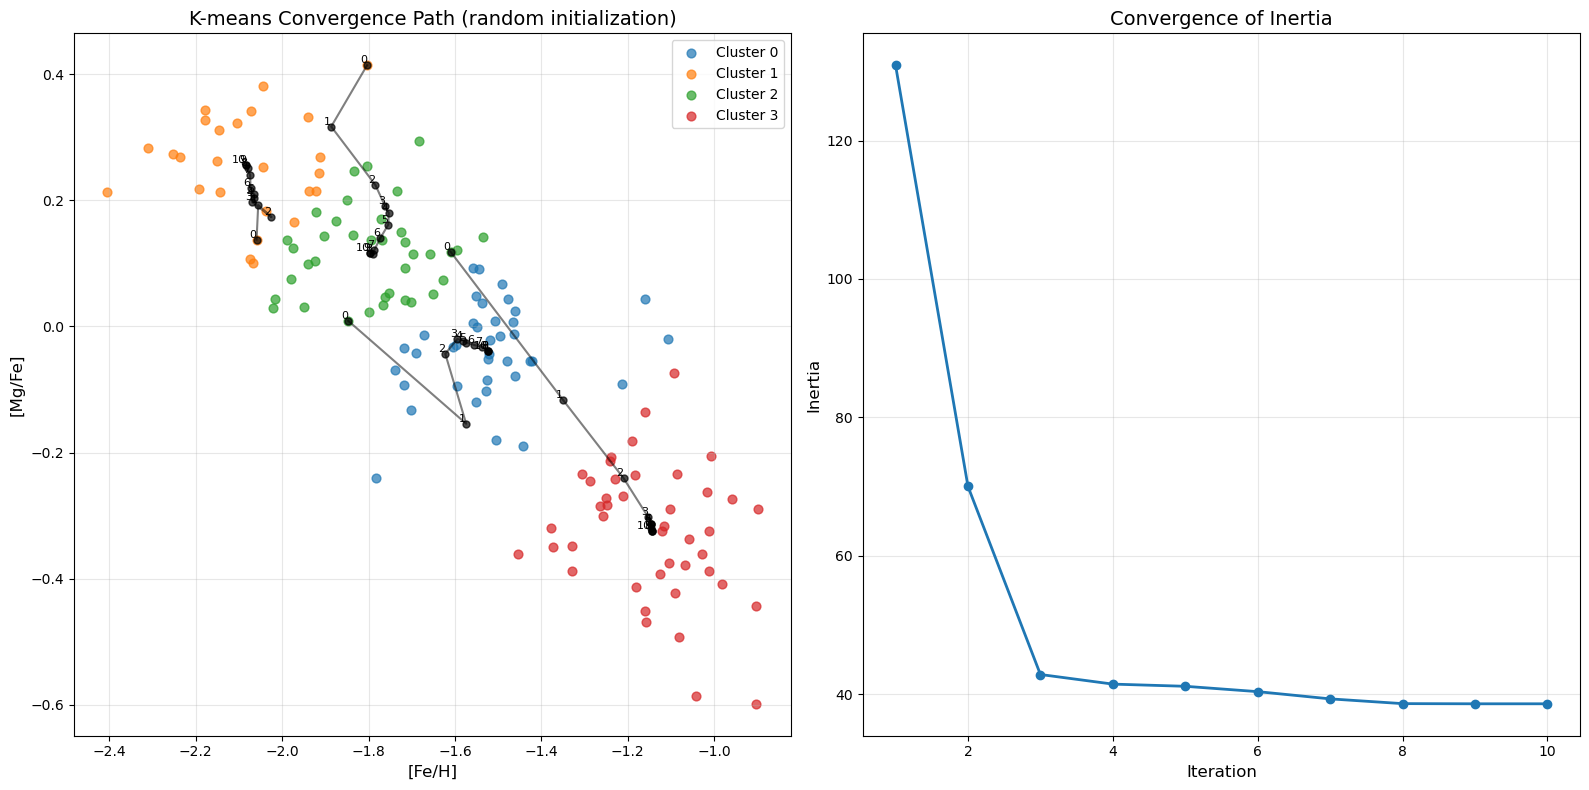

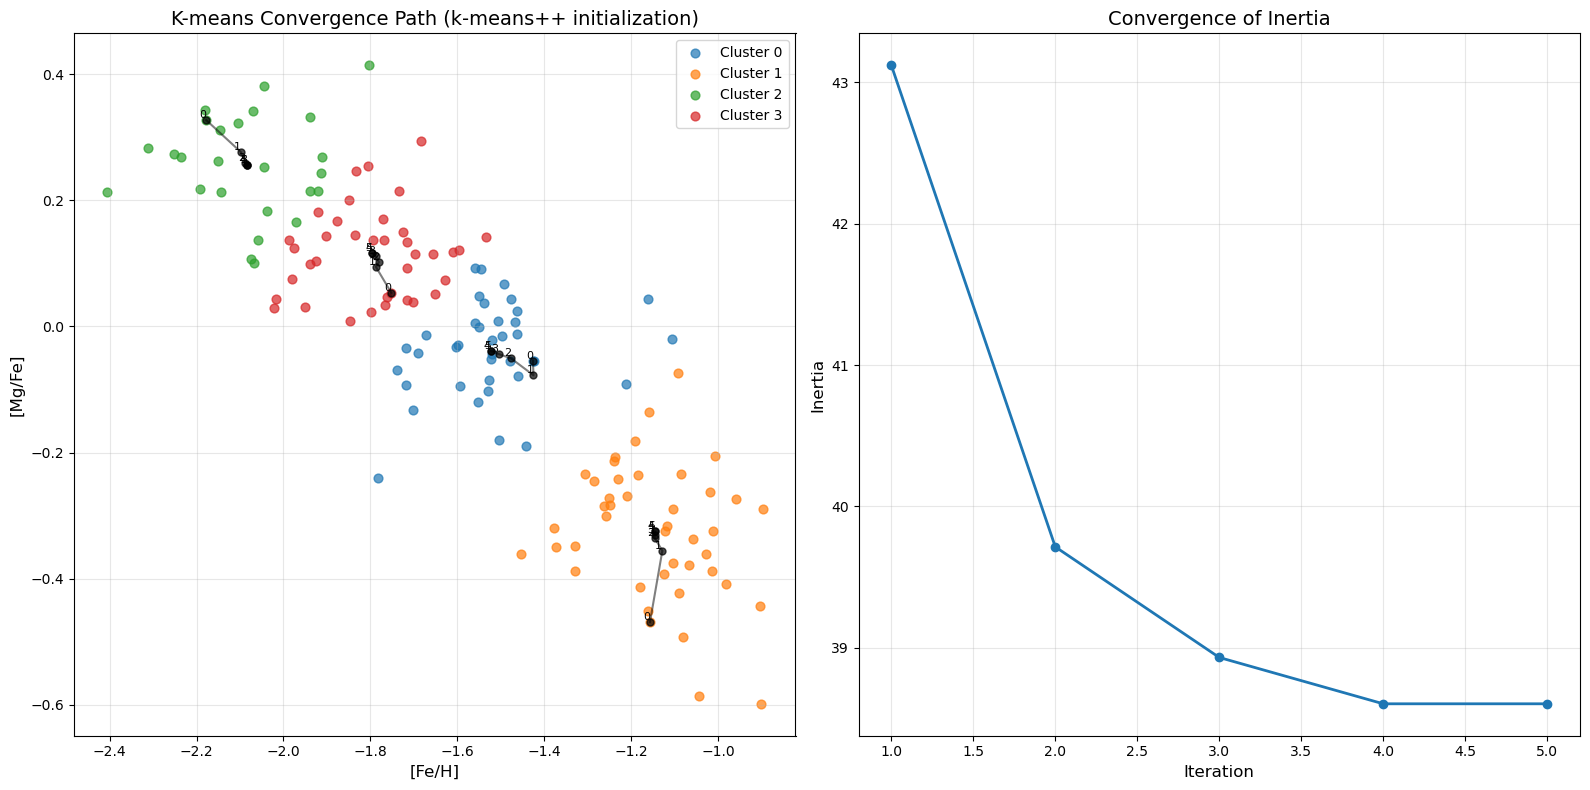

In [41]:
def visualize_kmeans_convergence(X, history, init_method='random'):
    """Visualize K-means convergence over iterations"""
    centroids_history = history['centroids']
    inertia_history = history['inertia']
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Plot the final data clustering in the first subplot
    final_centroids = centroids_history[-1]
    final_labels = assign_clusters(X_std, final_centroids)
    
    # Convert standardized centroids to original scale for plotting
    centroids_orig = [c * std_X + mean_X for c in centroids_history]
    
    # Plot data points colored by cluster
    for i in range(4):
        cluster_points = X[final_labels == i]
        ax1.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                   alpha=0.7, s=40, label=f'Cluster {i}')
    
    # Plot centroid paths
    for i in range(4):
        centroid_path = np.array([c[i] for c in centroids_orig])
        ax1.plot(centroid_path[:, 0], centroid_path[:, 1], 'k-', alpha=0.5)
        
        # Add markers for each iteration
        for j, centroid in enumerate(centroid_path):
            # Only plot every few iterations to avoid clutter
            if j % max(1, len(centroid_path) // 10) == 0 or j == len(centroid_path) - 1:
                ax1.plot(centroid[0], centroid[1], 'ko', alpha=0.7, markersize=5)
                ax1.annotate(str(j), (centroid[0], centroid[1]), 
                            fontsize=8, ha='right', va='bottom')
    
    ax1.set_xlabel('[Fe/H]', fontsize=12)
    ax1.set_ylabel('[Mg/Fe]', fontsize=12)
    ax1.set_title(f'K-means Convergence Path ({init_method} initialization)', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot inertia over iterations
    ax2.plot(range(1, len(inertia_history) + 1), inertia_history, 'o-', linewidth=2)
    ax2.set_xlabel('Iteration', fontsize=12)
    ax2.set_ylabel('Inertia', fontsize=12)
    ax2.set_title('Convergence of Inertia', fontsize=14)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Visualize convergence for both initialization methods
visualize_kmeans_convergence(X, random_history, 'random')
visualize_kmeans_convergence(X, kmpp_history, 'k-means++')

### Selecting the Optimal Number of Clusters

K-means requires us to specify the number of clusters (k) in advance, but how do we know what value of k to use? One common method is to examine the inertia (sum of squared distances to the nearest centroid) across different values of k.

As we increase the number of clusters, the inertia typically decreases because points are closer to their assigned centroids. We look for an "elbow" in the curve - a point of diminishing returns where adding more clusters doesn't significantly reduce inertia.

Let's analyze how inertia changes with different numbers of clusters in our dataset:

Computing K-means with k=2...
  Inertia: 93.4045
Computing K-means with k=3...
  Inertia: 47.2581
Computing K-means with k=4...
  Inertia: 38.6039
Computing K-means with k=5...
  Inertia: 30.9887
Computing K-means with k=6...
  Inertia: 26.5663
Computing K-means with k=7...
  Inertia: 23.1779
Computing K-means with k=8...
  Inertia: 20.9325
Computing K-means with k=9...
  Inertia: 18.0437


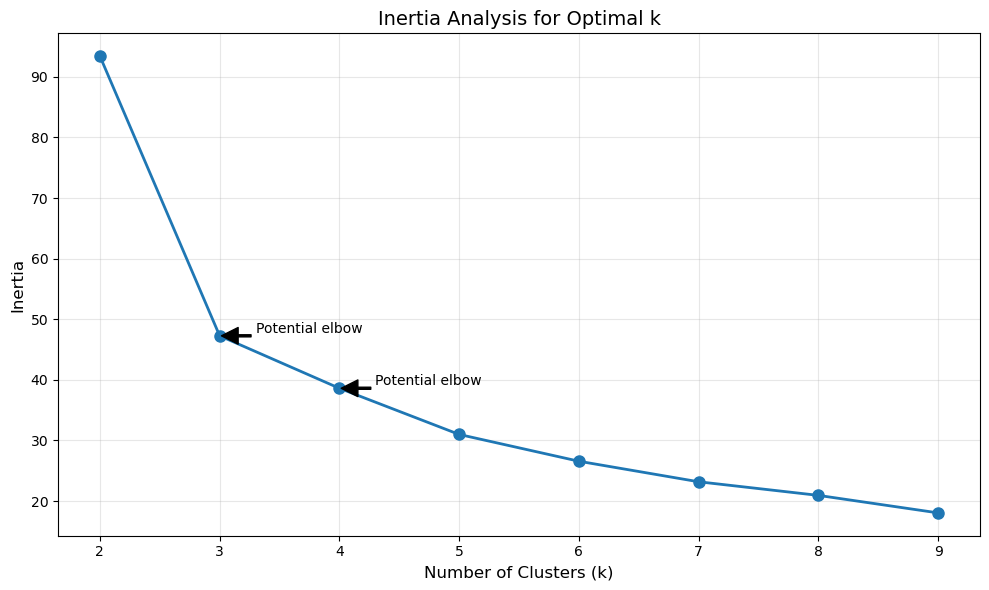

In [42]:
def inertia_analysis(X, k_range=range(2, 10), init_method='kmeans++', random_state=42):
    """
    Compute K-means inertia for different values of k
    
    Parameters:
    -----------
    X : array, shape (n_samples, n_features)
        The input data
    k_range : iterable
        Range of k values to try
    init_method : str
        Initialization method
    random_state : int or None
        Random seed for reproducibility
    
    Returns:
    --------
    inertias : list
        Inertia for each value of k
    """
    inertias = []
    
    for k in k_range:
        print(f"Computing K-means with k={k}...")
        _, _, inertia, _, _ = kmeans(X, k, init_method=init_method, random_state=random_state)
        inertias.append(inertia)
        print(f"  Inertia: {inertia:.4f}")
    
    return inertias

# Compute inertia for different numbers of clusters
k_range = range(2, 10)  # Testing k from 2 to 9
inertias = inertia_analysis(X_std, k_range, init_method='kmeans++')

# Plot the inertia curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, 'o-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.title('Inertia Analysis for Optimal k', fontsize=14)
plt.xticks(k_range)
plt.grid(True, alpha=0.3)
# Add annotation for potential elbow points
plt.annotate('Potential elbow', xy=(3, inertias[1]), xytext=(3.3, inertias[1]+0.5),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))
plt.annotate('Potential elbow', xy=(4, inertias[2]), xytext=(4.3, inertias[2]+0.5),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))
plt.tight_layout()
plt.show()

Looking at the inertia plot, we can observe a tentative "elbow" around k=3 or k=4. This suggests that there might be 3 or 4 distinct clusters in our data.
 
However, the signal is relatively weak, and the elbow isn't very pronounced. This indicates that while there are likely multiple clusters in our data, K-means might not be capturing the full complexity of the underlying structure. Additionally, our clusters might not be perfectly spherical, which also makes K-means analysis less robust.
 
In the next section, we'll explore Gaussian Mixture Models (GMMs), which offer a more flexible approach to clustering. We'll also use information criteria like BIC and AIC to more rigorously determine the optimal number of components.

## Part 2: Gaussian Mixture Models from Scratch

While K-means provides a simple and intuitive approach to clustering, it has several limitations:
- It assumes clusters are spherical and equally sized
- It makes hard assignments (each point belongs to exactly one cluster)
- It doesn't provide uncertainty estimates for the assignments

Gaussian Mixture Models (GMMs) address these limitations by providing a more flexible probabilistic approach to clustering. In a GMM, we model the data as being generated from a mixture of several Gaussian distributions.

### The Mathematical Foundation of GMMs

A Gaussian Mixture Model represents the probability density function of the data as a weighted sum of Gaussian distributions:

$$p(x) = \sum_{k=1}^K \pi_k \mathcal{N}(x|\mu_k, \Sigma_k)$$

Where:
- $\pi_k$ is the weight (or mixing coefficient) of the $k$-th Gaussian component
- $\mu_k$ is the mean of the $k$-th Gaussian component
- $\Sigma_k$ is the covariance matrix of the $k$-th Gaussian component
- $\mathcal{N}(x|\mu_k, \Sigma_k)$ is the multivariate Gaussian distribution

The weights must sum to 1: $\sum_{k=1}^K \pi_k = 1$

### The Expectation-Maximization (EM) Algorithm

GMMs are typically fitted using the Expectation-Maximization (EM) algorithm, which iteratively:

1. **E-step**: Computes the "responsibilities" - the probability that each data point belongs to each Gaussian component
2. **M-step**: Updates the parameters ($\pi_k$, $\mu_k$, $\Sigma_k$) based on these responsibilities

Let's implement each step of this algorithm, starting with a function to evaluate the probability density function of a multivariate normal distribution:

Multivariate normal PDF test:
[0.18377605 0.09435381 0.09435381]


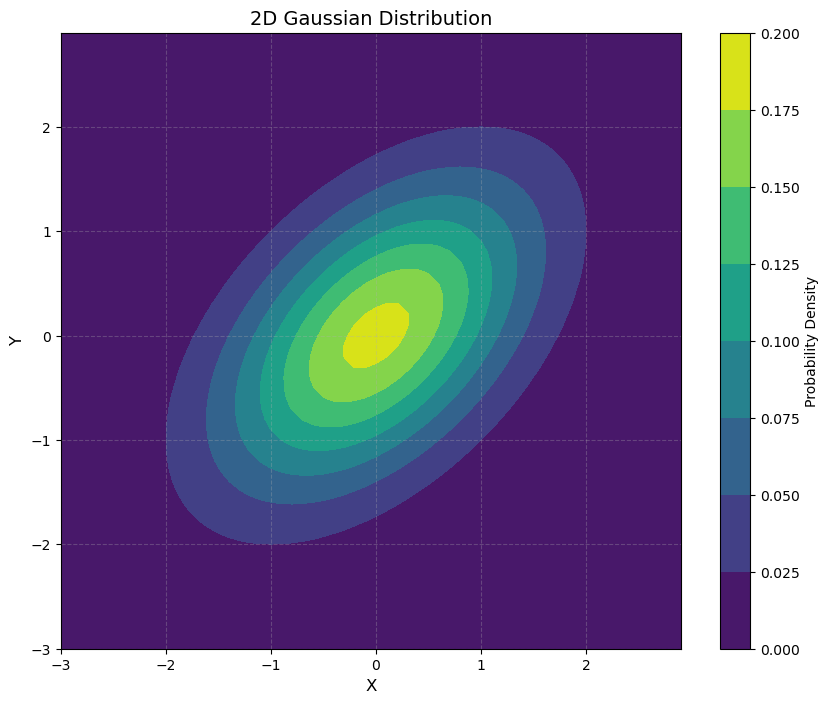

In [43]:
def multivariate_normal_pdf(X, mu, sigma):
    """
    Compute the PDF of a multivariate normal distribution
    
    Parameters:
    -----------
    X : array, shape (n_samples, n_features)
        The data points
    mu : array, shape (n_features,)
        The mean vector
    sigma : array, shape (n_features, n_features)
        The covariance matrix
    
    Returns:
    --------
    pdf_values : array, shape (n_samples,)
        The PDF values
    """
    n_features = X.shape[1]
    
    # Add small regularization to avoid numerical issues
    sigma_reg = sigma + np.eye(n_features) * 1e-6
    
    try:
        # Using SciPy's multivariate_normal for numerical stability
        return multivariate_normal.pdf(X, mean=mu, cov=sigma_reg)
    except np.linalg.LinAlgError:
        # If still encountering issues, use a more robust approach
        print("Warning: Covariance matrix is singular. Using diagonal covariance.")
        return multivariate_normal.pdf(X, mean=mu, cov=np.diag(np.diag(sigma_reg)))

# Test the multivariate normal PDF function
test_mu = np.array([0, 0])
test_sigma = np.array([[1, 0.5], [0.5, 1]])
test_x = np.array([[0, 0], [1, 1], [-1, -1]])

print("Multivariate normal PDF test:")
print(multivariate_normal_pdf(test_x, test_mu, test_sigma))

# Visualize the 2D Gaussian distribution
x, y = np.mgrid[-3:3:.1, -3:3:.1]
pos = np.dstack((x, y))
rv = multivariate_normal(mean=test_mu, cov=test_sigma)

plt.figure(figsize=(10, 8))
plt.contourf(x, y, rv.pdf(pos), cmap='viridis')
plt.colorbar(label='Probability Density')
plt.title('2D Gaussian Distribution', fontsize=14)
plt.xlabel('X', fontsize=12)
plt.ylabel('Y', fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
plt.show()

### Step 1: Initialization for GMM

Similar to K-means, initialization is important for GMM. A good initialization can lead to faster convergence and better final results. We'll initialize our GMM parameters as follows:

1. Run K-means to get initial cluster assignments
2. Set mixture weights to be equal (1/K) for all components
3. Set initial means to the K-means centroids
4. Calculate initial covariance matrices based on the points assigned to each cluster

Good initialization helps the EM algorithm converge faster and find better solutions.

Initial mixture weights:
[0.25 0.25 0.25 0.25]

Initial means:
[[ 0.15153266 -0.02505666]
 [ 1.19112794 -1.26529716]
 [-1.39187352  1.25491809]
 [-0.59945688  0.64829672]]

Initial covariances shape:
(4, 2, 2)


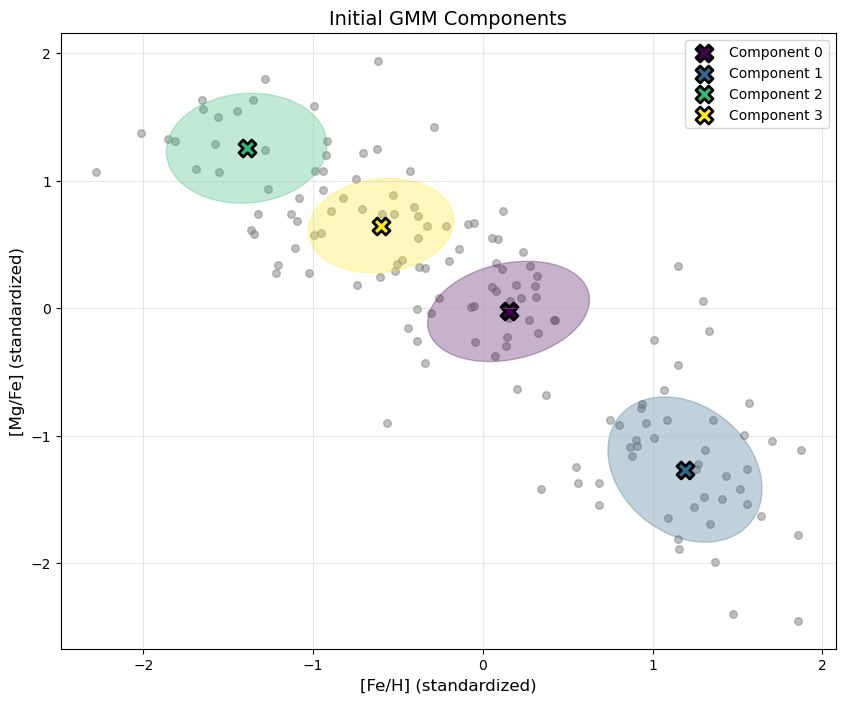

In [44]:
def initialize_gmm(X, k, init_method='kmeans++', random_state=None):
    """
    Initialize GMM parameters based on K-means clustering
    
    Parameters:
    -----------
    X : array, shape (n_samples, n_features)
        The input data
    k : int
        The number of components
    init_method : str
        Initialization method for K-means
    random_state : int or None
        Random seed for reproducibility
    
    Returns:
    --------
    weights : array, shape (k,)
        Initial mixture weights
    means : array, shape (k, n_features)
        Initial component means
    covariances : array, shape (k, n_features, n_features)
        Initial component covariances
    """
    n_samples, n_features = X.shape
    
    # Run K-means for initial clustering
    centroids, labels, _, _, _ = kmeans(X, k, init_method=init_method, random_state=random_state)
    
    # Initialize weights to be equal (1/K) for all components
    weights = np.ones(k) / k
    
    # Initialize means as the cluster centroids
    means = centroids
    
    # Initialize covariances based on cluster variances
    covariances = np.zeros((k, n_features, n_features))
    for i in range(k):
        cluster_points = X[labels == i]
        if len(cluster_points) > 1:  # Need at least 2 points to compute covariance
            covariances[i] = np.cov(cluster_points, rowvar=False)
        else:
            # For clusters with too few points, use diagonal covariance
            covariances[i] = np.eye(n_features)
            
        # Ensure positive definiteness by adding small regularization
        covariances[i] += np.eye(n_features) * 1e-6
    
    return weights, means, covariances

# Initialize GMM parameters for k=4
weights, means, covariances = initialize_gmm(X_std, k=4, init_method='kmeans++', random_state=42)

print("Initial mixture weights:")
print(weights)
print("\nInitial means:")
print(means)
print("\nInitial covariances shape:")
print(covariances.shape)

# Visualize the initialized Gaussian components
plt.figure(figsize=(10, 8))

# Plot data points
plt.scatter(X_std[:, 0], X_std[:, 1], s=30, alpha=0.5, color='gray')

# Plot the means and covariance ellipses
colors = plt.cm.viridis(np.linspace(0, 1, 4))
for i in range(4):
    # Get eigenvalues and eigenvectors of covariance
    v, w = np.linalg.eigh(covariances[i])
    # Order of eigenvalues
    order = v.argsort()[::-1]
    v, w = v[order], w[:, order]
    
    # Angle of largest eigenvector with x-axis
    angle = np.arctan2(w[1, 0], w[0, 0])
    angle = np.degrees(angle)
    
    # 95% confidence ellipse (chi-squared with 2 DOF is 5.991)
    v = 2.447 * np.sqrt(v)  # 95% ellipse
    
    # Create ellipse patches
    ell = plt.matplotlib.patches.Ellipse(
        xy=means[i], width=v[0], height=v[1],
        angle=angle, color=colors[i], alpha=0.3)
    plt.gca().add_patch(ell)
    
    # Plot means
    plt.scatter(means[i, 0], means[i, 1], s=150, marker='X', 
                color=colors[i], edgecolor='black', linewidth=2, 
                label=f'Component {i}')

plt.xlabel('[Fe/H] (standardized)', fontsize=12)
plt.ylabel('[Mg/Fe] (standardized)', fontsize=12)
plt.title('Initial GMM Components', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Step 2: E-step - Computing Responsibilities

In the Expectation step (E-step), we compute the "responsibilities" - the probability that each data point belongs to each Gaussian component. 

The responsibility of component $k$ for data point $x_n$ is defined as:

$$\gamma_{nk} = \frac{\pi_k \mathcal{N}(x_n|\mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j \mathcal{N}(x_n|\mu_j, \Sigma_j)}$$

Where:
- $\pi_k$ is the mixture weight of component $k$
- $\mathcal{N}(x_n|\mu_k, \Sigma_k)$ is the probability density of data point $x_n$ under component $k$
- The denominator is the total probability density across all components (normalization factor)

This step provides a soft assignment of data points to components, unlike the hard assignment in K-means. Each point has a probability of belonging to each component, summing to 1 across all components.

During the E-step, we also compute the log-likelihood of the data given the current model parameters, which helps us track convergence.

Responsibilities shape: (143, 4)
Log-likelihood: -294.1183619996357

Responsibilities for first 5 data points:
[[9.88886527e-03 4.40271821e-07 7.68240646e-03 9.82428288e-01]
 [9.75777506e-01 1.29288459e-04 4.06148089e-06 2.40891445e-02]
 [1.41638014e-01 2.14646559e-05 9.40579908e-04 8.57399941e-01]
 [5.42298613e-03 9.94577014e-01 1.86083770e-16 2.62875458e-10]
 [6.43683816e-14 2.26827450e-17 9.99951779e-01 4.82212295e-05]]


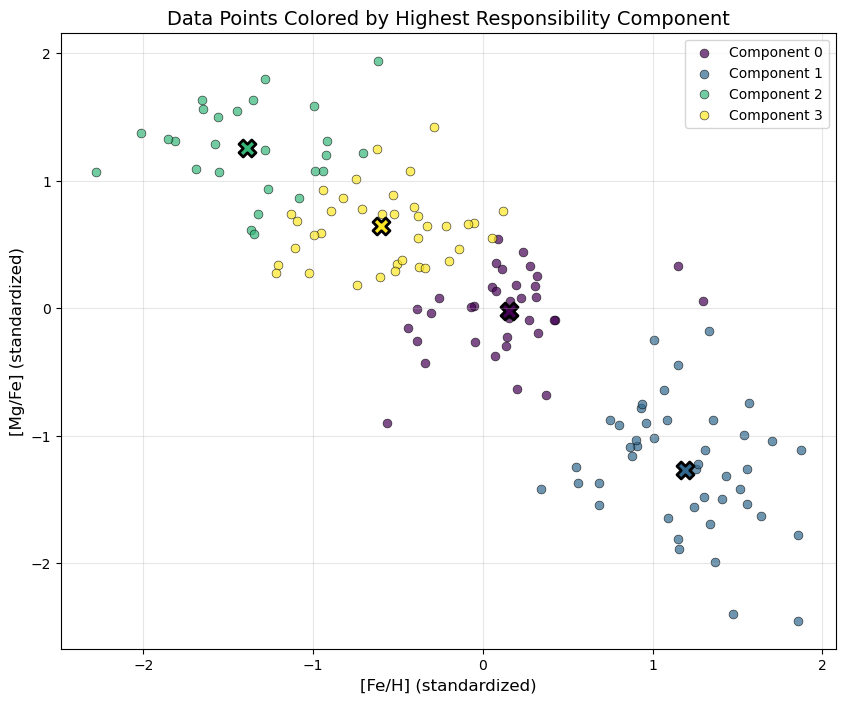

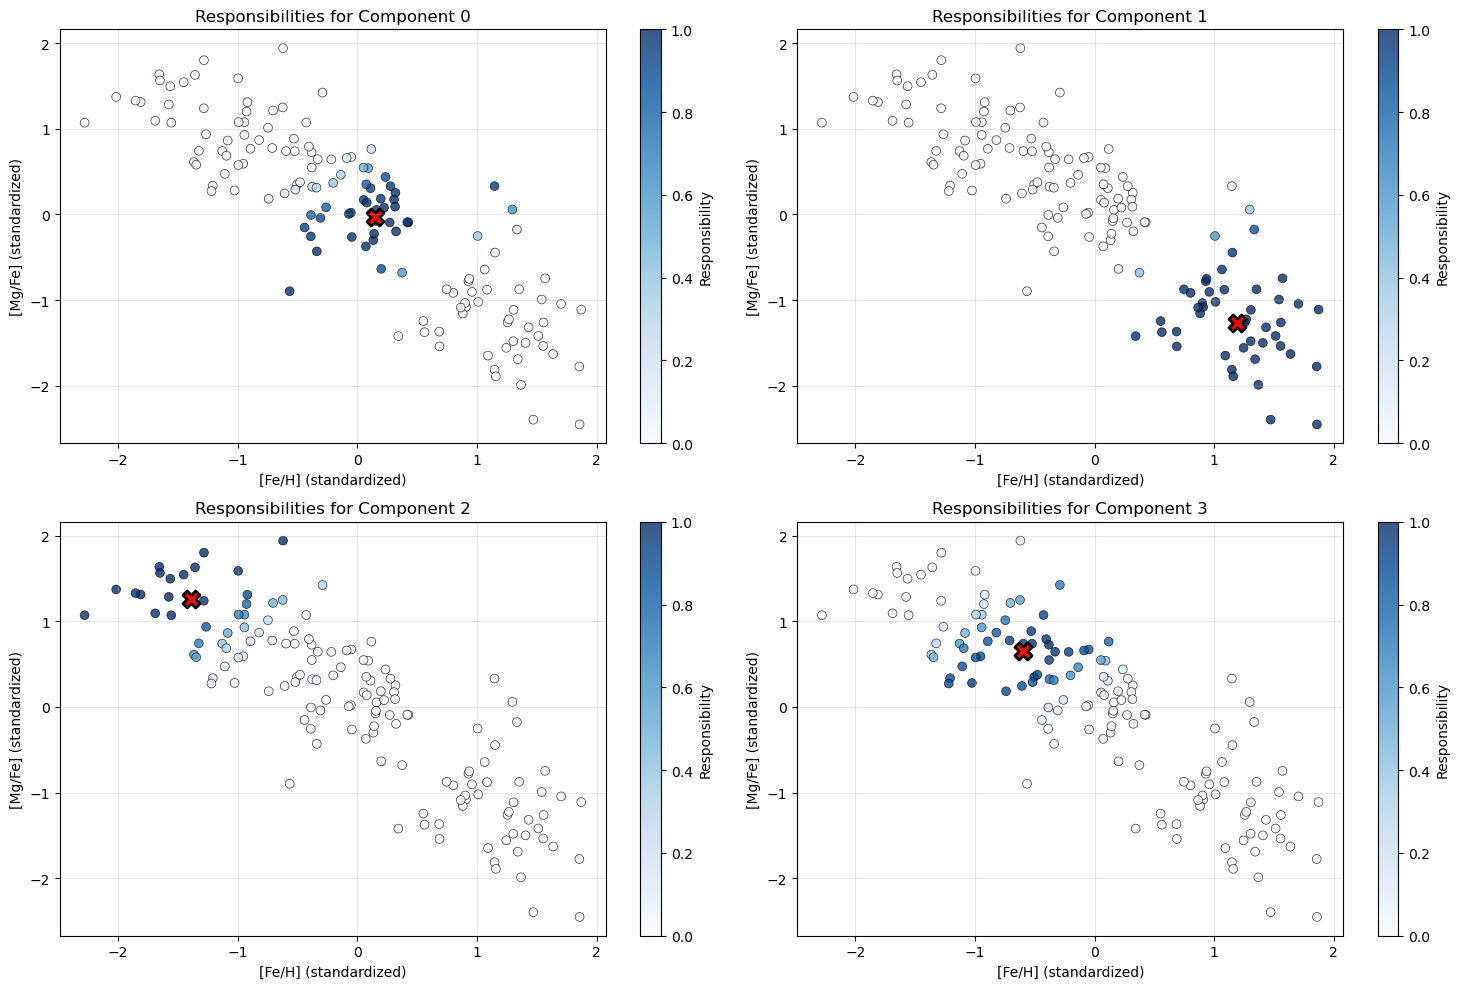

In [45]:
def e_step(X, weights, means, covariances):
    """
    E-step: Compute responsibilities
    
    Parameters:
    -----------
    X : array, shape (n_samples, n_features)
        The input data
    weights : array, shape (k,)
        Mixture weights
    means : array, shape (k, n_features)
        Component means
    covariances : array, shape (k, n_features, n_features)
        Component covariances
    
    Returns:
    --------
    responsibilities : array, shape (n_samples, k)
        Responsibility of each component for each sample
    log_likelihood : float
        Log-likelihood of the data under the current model
    """
    n_samples, _ = X.shape
    k = len(weights)
    
    # Initialize array to store weighted probabilities for each component
    weighted_prob = np.zeros((n_samples, k))
    
    # Compute weighted probability for each component
    for i in range(k):
        # Compute probability density
        prob = multivariate_normal_pdf(X, means[i], covariances[i])
        # Apply weight
        weighted_prob[:, i] = weights[i] * prob
    
    # Compute sum across components (total probability)
    total_prob = np.sum(weighted_prob, axis=1)
    
    # Compute responsibilities (normalize weighted probabilities)
    # Handle potential numerical issues
    responsibilities = weighted_prob / total_prob.reshape(-1, 1)
    
    # Compute log-likelihood (avoid log(0) by adding small epsilon)
    log_likelihood = np.sum(np.log(total_prob + 1e-10))
    
    return responsibilities, log_likelihood

# Test E-step with our initialized parameters
responsibilities, log_likelihood = e_step(X_std, weights, means, covariances)

print("Responsibilities shape:", responsibilities.shape)
print("Log-likelihood:", log_likelihood)
print("\nResponsibilities for first 5 data points:")
print(responsibilities[:5])

# Visualize the responsibilities
plt.figure(figsize=(10, 8))

# Create a scatter plot where point color is based on highest responsibility
max_resp_idx = np.argmax(responsibilities, axis=1)
colors = plt.cm.viridis(np.linspace(0, 1, 4))

# Plot data points colored by their highest responsibility component
for i in range(4):
    # Select points where this component has highest responsibility
    idx = np.where(max_resp_idx == i)[0]
    plt.scatter(X_std[idx, 0], X_std[idx, 1], 
               color=colors[i], alpha=0.7, s=40, edgecolor='black', linewidth=0.5,
               label=f'Component {i}')

# Plot means
for i in range(4):
    plt.scatter(means[i, 0], means[i, 1], s=150, marker='X', 
                color=colors[i], edgecolor='black', linewidth=2)

plt.xlabel('[Fe/H] (standardized)', fontsize=12)
plt.ylabel('[Mg/Fe] (standardized)', fontsize=12)
plt.title('Data Points Colored by Highest Responsibility Component', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Visualize responsibilities as continuous values
plt.figure(figsize=(15, 10))

# Create 4 subplots, one for each component
for i in range(4):
    plt.subplot(2, 2, i+1)
    
    # Plot points with color intensity proportional to responsibility
    # Add black edge to every point for better visibility
    scatter = plt.scatter(X_std[:, 0], X_std[:, 1], 
                         c=responsibilities[:, i], cmap='Blues', 
                         alpha=0.8, s=40, vmin=0, vmax=1,
                         edgecolor='black', linewidth=0.5)
    
    # Plot mean
    plt.scatter(means[i, 0], means[i, 1], s=150, marker='X', 
                color='red', edgecolor='black', linewidth=2)
    
    plt.xlabel('[Fe/H] (standardized)', fontsize=10)
    plt.ylabel('[Mg/Fe] (standardized)', fontsize=10)
    plt.title(f'Responsibilities for Component {i}', fontsize=12)
    plt.colorbar(scatter, label='Responsibility')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Step 3: M-step - Updating Parameters

After computing the responsibilities in the E-step, we proceed to the Maximization step (M-step), where we update the model parameters to maximize the expected log-likelihood based on the current responsibilities.

We first define the effective number of points in each component:
$$N_k = \sum_{n=1}^N \gamma_{nk}$$

This represents the sum of responsibilities for component k across all data points.

The update equations are then:

1. Update mixture weights:
   $$\pi_k^{new} = \frac{N_k}{N}$$

2. Update means:
   $$\mu_k^{new} = \frac{1}{N_k}\sum_{n=1}^N \gamma_{nk} x_n$$

3. Update covariance matrices:
   $$\Sigma_k^{new} = \frac{1}{N_k}\sum_{n=1}^N \gamma_{nk} (x_n - \mu_k^{new})(x_n - \mu_k^{new})^T$$

Where:
- $\gamma_{nk}$ is the responsibility of component $k$ for data point $x_n$
- $N$ is the total number of data points
- $N_k$ is the effective number of points in component $k$

The M-step ensures that the model parameters are optimally adjusted to fit the data according to the current soft assignments.

Updated mixture weights:
[0.25740617 0.31071121 0.18151315 0.25036947]

Updated means:
[[ 0.11018892 -0.00488066]
 [ 1.17727706 -1.23372905]
 [-1.33588901  1.24693086]
 [-0.60580495  0.63208749]]

Sum of weights (should be close to 1): 1.0


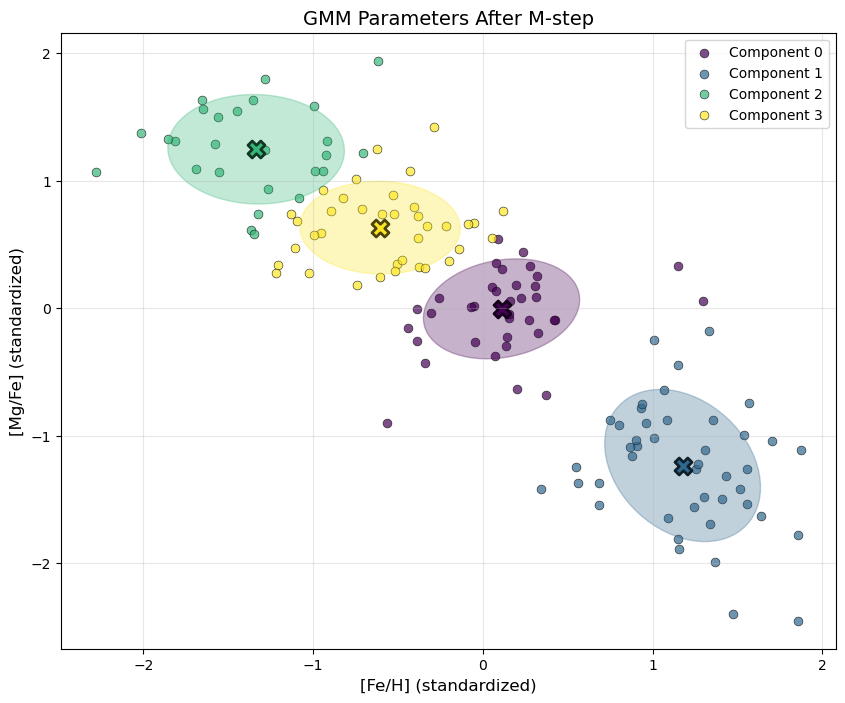

In [46]:
def m_step(X, responsibilities):
    """
    M-step: Update parameters based on responsibilities
    
    Parameters:
    -----------
    X : array, shape (n_samples, n_features)
        The input data
    responsibilities : array, shape (n_samples, k)
        Responsibility of each component for each sample
    
    Returns:
    --------
    weights : array, shape (k,)
        Updated mixture weights
    means : array, shape (k, n_features)
        Updated component means
    covariances : array, shape (k, n_features, n_features)
        Updated component covariances
    """
    n_samples, n_features = X.shape
    k = responsibilities.shape[1]
    
    # Compute sum of responsibilities for each component (effective number of points)
    N_k = np.sum(responsibilities, axis=0)
    
    # Update weights
    weights = N_k / n_samples
    
    # Initialize arrays for means and covariances
    means = np.zeros((k, n_features))
    covariances = np.zeros((k, n_features, n_features))
    
    # Update means and covariances
    for i in range(k):
        # Compute weighted sum of data points for mean update
        weighted_sum = np.zeros(n_features)
        for n in range(n_samples):
            weighted_sum += responsibilities[n, i] * X[n]
        
        # Update mean
        if N_k[i] > 0:  # Avoid division by zero
            means[i] = weighted_sum / N_k[i]
        
        # Compute covariance matrix
        cov = np.zeros((n_features, n_features))
        for n in range(n_samples):
            # Compute outer product for covariance
            diff = X[n] - means[i]
            outer_prod = np.outer(diff, diff)
            # Weight by responsibility
            cov += responsibilities[n, i] * outer_prod
        
        # Update covariance
        if N_k[i] > 0:  # Avoid division by zero
            covariances[i] = cov / N_k[i]
            
        # Add small regularization to ensure positive definiteness
        covariances[i] += np.eye(n_features) * 1e-6
    
    return weights, means, covariances

# Update parameters using our responsibilities
new_weights, new_means, new_covariances = m_step(X_std, responsibilities)

print("Updated mixture weights:")
print(new_weights)
print("\nUpdated means:")
print(new_means)
print("\nSum of weights (should be close to 1):", np.sum(new_weights))

# Visualize the parameters after M-step
plt.figure(figsize=(10, 8))

# Plot data points with colors based on highest responsibility
max_resp_idx = np.argmax(responsibilities, axis=1)
colors = plt.cm.viridis(np.linspace(0, 1, 4))

for i in range(4):
    idx = np.where(max_resp_idx == i)[0]
    plt.scatter(X_std[idx, 0], X_std[idx, 1], 
               color=colors[i], alpha=0.7, s=40, 
               edgecolor='black', linewidth=0.5,
               label=f'Component {i}')

# Plot updated means and covariance ellipses
for i in range(4):
    # Plot updated means
    plt.scatter(new_means[i, 0], new_means[i, 1], s=150, marker='X', 
                color=colors[i], edgecolor='black', linewidth=2)

    # Plot updated covariance ellipses
    v, w = np.linalg.eigh(new_covariances[i])
    order = v.argsort()[::-1]
    v, w = v[order], w[:, order]
    angle = np.arctan2(w[1, 0], w[0, 0])
    angle = np.degrees(angle)
    v = 2.447 * np.sqrt(v)  # 95% ellipse
    
    ell = plt.matplotlib.patches.Ellipse(
        xy=new_means[i], width=v[0], height=v[1],
        angle=angle, color=colors[i], alpha=0.3)
    plt.gca().add_patch(ell)

plt.xlabel('[Fe/H] (standardized)', fontsize=12)
plt.ylabel('[Mg/Fe] (standardized)', fontsize=12)
plt.title('GMM Parameters After M-step', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Step 4: Putting It All Together - The Complete EM Algorithm for GMM

Now we can combine the E-step and M-step into the full Expectation-Maximization (EM) algorithm for fitting GMMs:

1. Initialize parameters (mixture weights, means, covariances)
2. Repeat until convergence:
   - **E-step**: Compute responsibilities (posterior probabilities)
   - **M-step**: Update parameters based on these responsibilities
   - Check for convergence using the log-likelihood

The EM algorithm is guaranteed to increase the log-likelihood at each iteration (or at least not decrease it). We consider the algorithm converged when the change in log-likelihood between iterations falls below a specified threshold.

Let's implement the full EM algorithm and apply it to our stellar data:

GMM converged in 65 iterations
Final log-likelihood: -278.2467

Final mixture weights:
[0.26328703 0.33043626 0.07468248 0.33159422]

Final means (standardized):
[[ 0.01837796  0.05695715]
 [ 1.16518213 -1.16067023]
 [-1.58383853  1.51209318]
 [-0.81898929  0.77083546]]

Final means (original scale):
[[-1.57108805 -0.02016881]
 [-1.15407061 -0.30076626]
 [-2.15370907  0.31516159]
 [-1.87558358  0.14434165]]


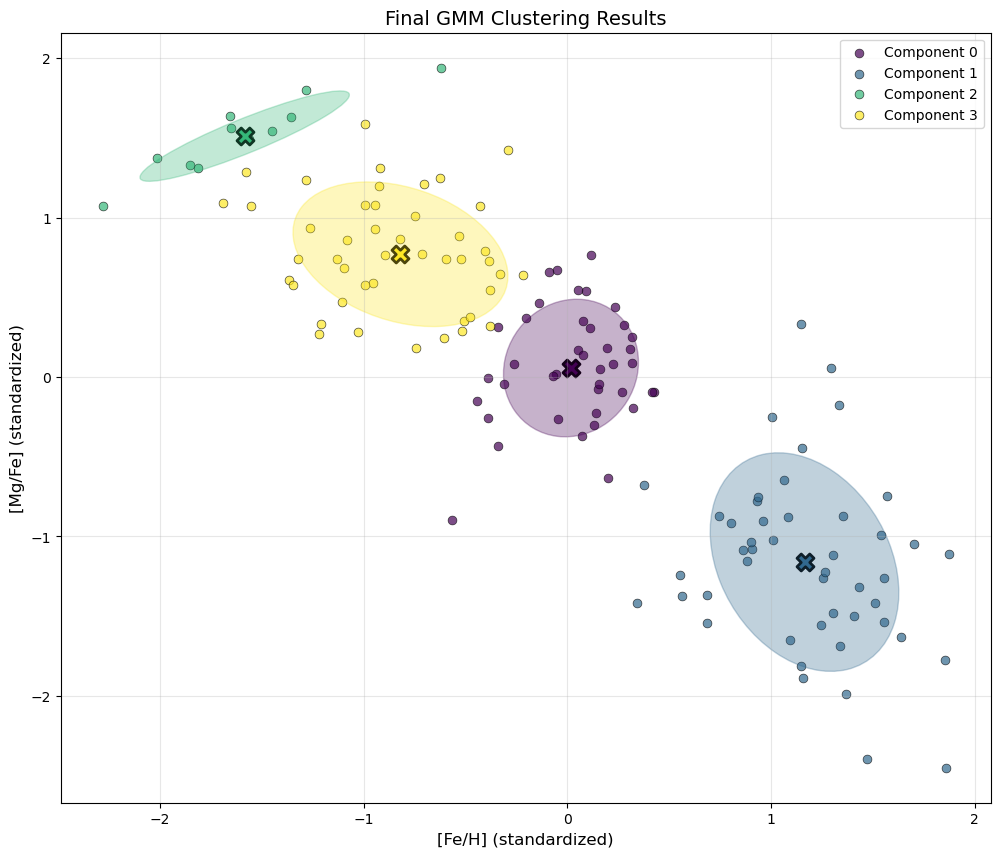

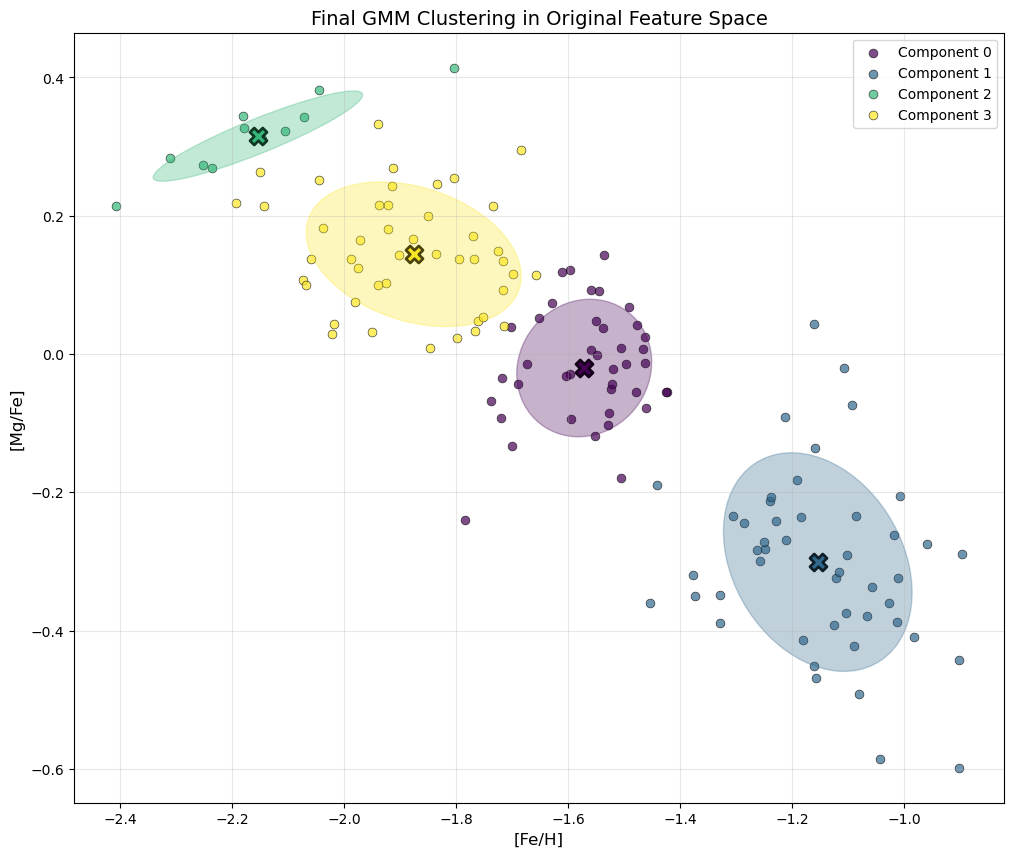

In [47]:
def fit_gmm(X, k, max_iter=100, tol=1e-4, init_method='kmeans++', random_state=None):
    """
    Fit a Gaussian Mixture Model using the EM algorithm
    
    Parameters:
    -----------
    X : array, shape (n_samples, n_features)
        The input data
    k : int
        The number of components
    max_iter : int
        Maximum number of iterations
    tol : float
        Convergence tolerance (change in log-likelihood)
    init_method : str
        Initialization method for K-means
    random_state : int or None
        Random seed for reproducibility
    
    Returns:
    --------
    weights : array, shape (k,)
        Mixture weights
    means : array, shape (k, n_features)
        Component means
    covariances : array, shape (k, n_features, n_features)
        Component covariances
    responsibilities : array, shape (n_samples, k)
        Final responsibilities
    log_likelihood : float
        Final log-likelihood
    n_iter : int
        Number of iterations run
    history : dict
        Dictionary containing history for visualization
    """
    # Initialize parameters
    weights, means, covariances = initialize_gmm(X, k, init_method, random_state)
    
    # Initialize history
    history = {
        'log_likelihood': [],
        'weights': [weights.copy()],
        'means': [means.copy()],
        'covariances': [covariances.copy()]
    }
    
    # Initialize log-likelihood
    old_log_likelihood = -np.inf
    
    # EM iterations
    n_iter = 0
    for i in range(max_iter):
        # E-step
        responsibilities, log_likelihood = e_step(X, weights, means, covariances)
        
        # Store log-likelihood
        history['log_likelihood'].append(log_likelihood)
        
        # Check for convergence
        if abs(log_likelihood - old_log_likelihood) < tol:
            break
        
        old_log_likelihood = log_likelihood
        
        # M-step
        weights, means, covariances = m_step(X, responsibilities)
        
        # Store parameters
        history['weights'].append(weights.copy())
        history['means'].append(means.copy())
        history['covariances'].append(covariances.copy())
        
        n_iter += 1
    
    # Final E-step to get responsibilities
    responsibilities, log_likelihood = e_step(X, weights, means, covariances)
    
    return weights, means, covariances, responsibilities, log_likelihood, n_iter, history

# Fit GMM with 4 components
weights, means, covariances, responsibilities, log_likelihood, n_iter, history = fit_gmm(
    X_std, k=4, init_method='kmeans++', random_state=42)

print(f"GMM converged in {n_iter} iterations")
print(f"Final log-likelihood: {log_likelihood:.4f}")
print("\nFinal mixture weights:")
print(weights)
print("\nFinal means (standardized):")
print(means)
print("\nFinal means (original scale):")
print(means * std_X + mean_X)

# Visualize the final GMM results
plt.figure(figsize=(12, 10))

# Plot data points with colors based on highest responsibility
max_resp_idx = np.argmax(responsibilities, axis=1)
colors = plt.cm.viridis(np.linspace(0, 1, 4))

for i in range(4):
    idx = np.where(max_resp_idx == i)[0]
    plt.scatter(X_std[idx, 0], X_std[idx, 1], 
               color=colors[i], alpha=0.7, s=40, 
               edgecolor='black', linewidth=0.5,
               label=f'Component {i}')

# Plot means and covariance ellipses
for i in range(4):
    # Plot means
    plt.scatter(means[i, 0], means[i, 1], s=150, marker='X', 
                color=colors[i], edgecolor='black', linewidth=2)

    # Plot covariance ellipses
    v, w = np.linalg.eigh(covariances[i])
    order = v.argsort()[::-1]
    v, w = v[order], w[:, order]
    angle = np.arctan2(w[1, 0], w[0, 0])
    angle = np.degrees(angle)
    v = 2.447 * np.sqrt(v)  # 95% ellipse
    
    ell = plt.matplotlib.patches.Ellipse(
        xy=means[i], width=v[0], height=v[1],
        angle=angle, color=colors[i], alpha=0.3)
    plt.gca().add_patch(ell)

plt.xlabel('[Fe/H] (standardized)', fontsize=12)
plt.ylabel('[Mg/Fe] (standardized)', fontsize=12)
plt.title('Final GMM Clustering Results', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Also show in original feature space for better interpretability
plt.figure(figsize=(12, 10))

# Convert standardized values back to original
means_orig = means * std_X + mean_X

# Plot data points with colors based on highest responsibility
for i in range(4):
    idx = np.where(max_resp_idx == i)[0]
    plt.scatter(X[idx, 0], X[idx, 1], 
               color=colors[i], alpha=0.7, s=40, 
               edgecolor='black', linewidth=0.5,
               label=f'Component {i}')

# Plot means
for i in range(4):
    plt.scatter(means_orig[i, 0], means_orig[i, 1], s=150, marker='X', 
                color=colors[i], edgecolor='black', linewidth=2)

    # Calculate covariance in original scale
    cov_orig = np.diag(std_X) @ covariances[i] @ np.diag(std_X)
    
    # Plot covariance ellipses in original scale
    v, w = np.linalg.eigh(cov_orig)
    order = v.argsort()[::-1]
    v, w = v[order], w[:, order]
    angle = np.arctan2(w[1, 0], w[0, 0])
    angle = np.degrees(angle)
    v = 2.447 * np.sqrt(v)  # 95% ellipse
    
    ell = plt.matplotlib.patches.Ellipse(
        xy=means_orig[i], width=v[0], height=v[1],
        angle=angle, color=colors[i], alpha=0.3)
    plt.gca().add_patch(ell)

plt.xlabel('[Fe/H]', fontsize=12)
plt.ylabel('[Mg/Fe]', fontsize=12)
plt.title('Final GMM Clustering in Original Feature Space', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Visualizing GMM Convergence

Now let's examine how the GMM parameters and log-likelihood evolve during the EM algorithm. This will help us understand the convergence behavior of the algorithm.

We'll visualize:
1. How the log-likelihood increases over iterations
2. How the means of the Gaussian components move during training
3. How the covariance matrices (shown as ellipses) change in shape and orientation

These visualizations provide insight into how the EM algorithm iteratively refines the model to better fit the underlying data distribution.

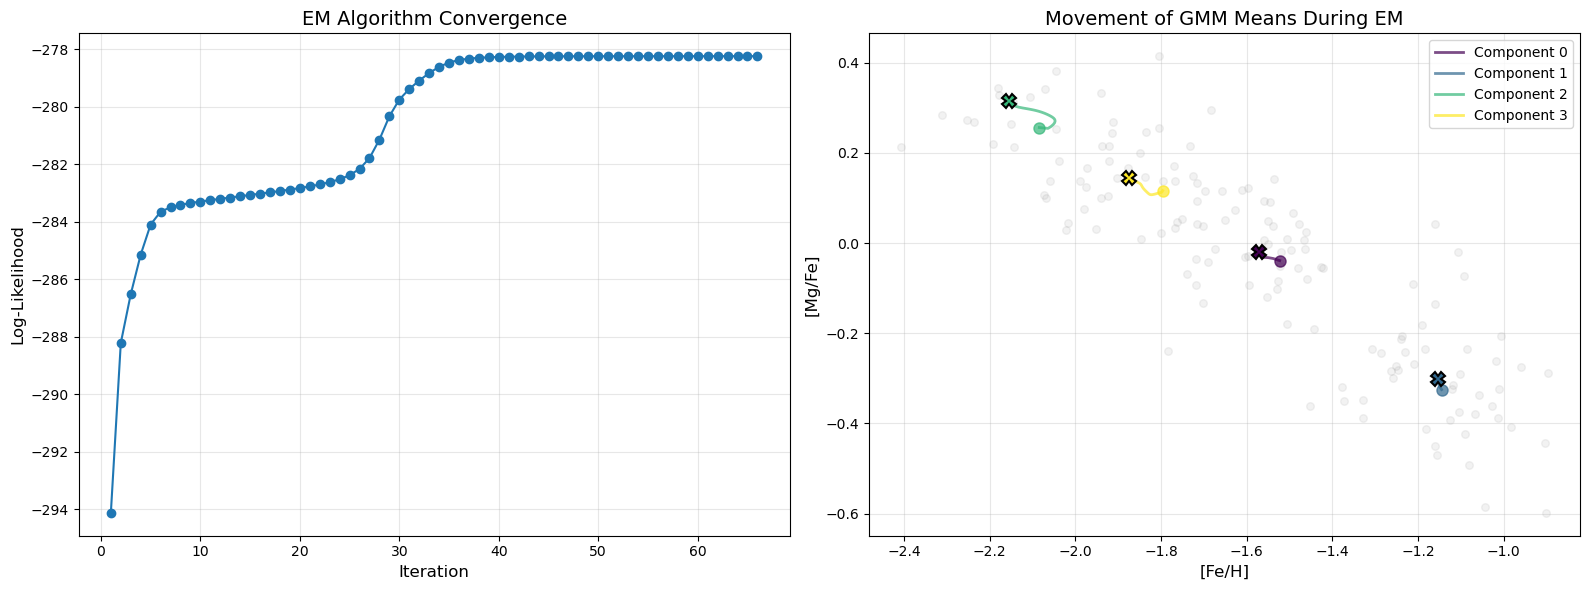

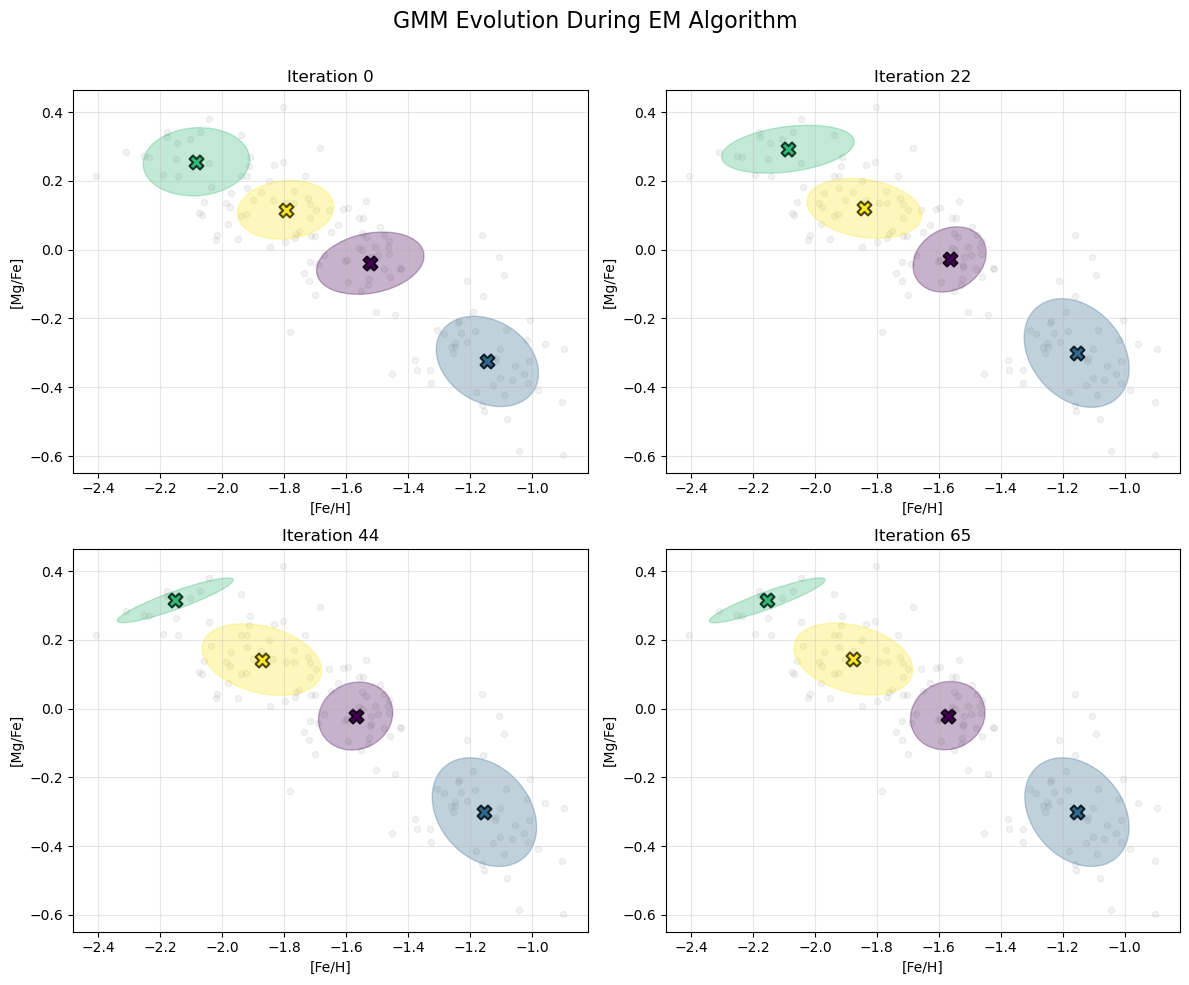

In [48]:
def visualize_gmm_convergence(X, history):
    """Visualize GMM convergence over iterations"""
    log_likelihood_history = history['log_likelihood']
    means_history = history['means']
    
    plt.figure(figsize=(16, 6))
    
    # Plot 1: Log-likelihood over iterations
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(log_likelihood_history) + 1), log_likelihood_history, 'o-')
    plt.xlabel('Iteration', fontsize=12)
    plt.ylabel('Log-Likelihood', fontsize=12)
    plt.title('EM Algorithm Convergence', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Movement of means in original feature space
    plt.subplot(1, 2, 2)
    
    # Convert standardized means to original scale for plotting
    means_orig = [m * std_X + mean_X for m in means_history]
    
    # Plot data points in background
    plt.scatter(X[:, 0], X[:, 1], alpha=0.1, s=30, color='gray')
    
    # Create colors for the different components
    colors = plt.cm.viridis(np.linspace(0, 1, 4))
    
    # Plot mean paths
    for i in range(4):
        mean_path = np.array([m[i] for m in means_orig])
        plt.plot(mean_path[:, 0], mean_path[:, 1], '-', color=colors[i], alpha=0.7, 
                linewidth=2, label=f'Component {i}')
        
        # Mark the start and end points
        plt.plot(mean_path[0, 0], mean_path[0, 1], 'o', color=colors[i], alpha=0.7, markersize=8)
        plt.plot(mean_path[-1, 0], mean_path[-1, 1], 'X', color=colors[i], alpha=1, 
                markersize=10, markeredgecolor='black', markeredgewidth=1.5)
    
    plt.xlabel('[Fe/H]', fontsize=12)
    plt.ylabel('[Mg/Fe]', fontsize=12)
    plt.title('Movement of GMM Means During EM', fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Create an animation of the GMM evolution (if there are enough iterations)
    if len(means_history) > 3:
        plt.figure(figsize=(12, 10))
        
        # Select a subset of iterations to visualize (to avoid too many plots)
        n_iters = len(means_history)
        iters_to_show = [0, n_iters//3, 2*n_iters//3, n_iters-1]  # beginning, 1/3, 2/3, end
        
        for idx, iter_idx in enumerate(iters_to_show):
            plt.subplot(2, 2, idx+1)
            
            # Convert means to original scale
            means_iter = means_history[iter_idx] * std_X + mean_X
            
            # If we have covariances, convert them too
            if 'covariances' in history and iter_idx < len(history['covariances']):
                covariances_iter = history['covariances'][iter_idx]
            else:
                covariances_iter = None
                
            # Plot data points
            plt.scatter(X[:, 0], X[:, 1], alpha=0.1, s=20, color='gray')
            
            # Plot means
            for i in range(4):
                plt.scatter(means_iter[i, 0], means_iter[i, 1], s=100, marker='X', 
                           color=colors[i], edgecolor='black', linewidth=1.5)
                
                # Plot covariance ellipses if available
                if covariances_iter is not None:
                    # Convert covariance to original scale
                    cov_orig = np.diag(std_X) @ covariances_iter[i] @ np.diag(std_X)
                    
                    # Calculate ellipse parameters
                    v, w = np.linalg.eigh(cov_orig)
                    order = v.argsort()[::-1]
                    v, w = v[order], w[:, order]
                    angle = np.arctan2(w[1, 0], w[0, 0])
                    angle = np.degrees(angle)
                    v = 2.447 * np.sqrt(v)  # 95% ellipse
                    
                    ell = plt.matplotlib.patches.Ellipse(
                        xy=means_iter[i], width=v[0], height=v[1],
                        angle=angle, color=colors[i], alpha=0.3)
                    plt.gca().add_patch(ell)
            
            plt.xlabel('[Fe/H]', fontsize=10)
            plt.ylabel('[Mg/Fe]', fontsize=10)
            plt.title(f'Iteration {iter_idx}', fontsize=12)
            plt.grid(True, alpha=0.3)
        
        plt.suptitle('GMM Evolution During EM Algorithm', fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)  # Adjust for suptitle
        plt.show()

# Visualize GMM convergence
visualize_gmm_convergence(X, history)

### Model Selection for GMM: BIC and AIC

Like with K-means, we need to determine the optimal number of components for our GMM. Two common criteria for model selection are:

1. **Bayesian Information Criterion (BIC)**: The BIC, introduced by Schwarz (1978), is derived from a Bayesian approach to model selection. It approximates the Bayes factor, which compares the posterior probabilities of different models. For a GMM with $K$ components, the BIC is defined as:

\begin{equation}
\text{BIC} = -2\ln(\hat{L}) + P\ln(N)
\end{equation}

where:
- $\hat{L}$ is the maximum likelihood of the model (the likelihood at the optimal parameter values)
- $P$ is the number of free parameters in the model
- $N$ is the number of data points

2. **Akaike Information Criterion (AIC)**: The AIC is another model selection criterion, which estimates the relative quality of statistical models. For a GMM, it is defined as:

\begin{equation}
\text{AIC} = -2\ln(\hat{L}) + 2P
\end{equation}

For both criteria, **lower values indicate better models**. These criteria balance the goodness of fit (measured by the log-likelihood) with model complexity (measured by the number of parameters), but BIC penalizes complexity more strongly, especially for large datasets.
 
Let's calculate the number of free parameters in a GMM with $K$ components in $D$ dimensions:
- $K-1$ free parameters for the mixture weights (they sum to 1)
- $K \times D$ parameters for the means
- $K \times D \times (D+1)/2$ parameters for the covariance matrices (symmetric)
 
For our 2D data, with $K$ components, we have: $P = (K-1) + 2K + K \times 3 = 6K - 1$ parameters.
 
Let's implement these criteria and use them to find the optimal number of GMM components:

Fitting GMM with 1 components...
  Log-likelihood: -308.87
  Parameters: 5
  AIC: 627.73
  BIC: 642.54
Fitting GMM with 2 components...
  Log-likelihood: -292.98
  Parameters: 11
  AIC: 607.96
  BIC: 640.55
Fitting GMM with 3 components...
  Log-likelihood: -286.77
  Parameters: 17
  AIC: 607.54
  BIC: 657.91
Fitting GMM with 4 components...
  Log-likelihood: -278.25
  Parameters: 23
  AIC: 602.49
  BIC: 670.64
Fitting GMM with 5 components...
  Log-likelihood: -269.02
  Parameters: 29
  AIC: 596.05
  BIC: 681.97
Fitting GMM with 6 components...
  Log-likelihood: -264.20
  Parameters: 35
  AIC: 598.40
  BIC: 702.10


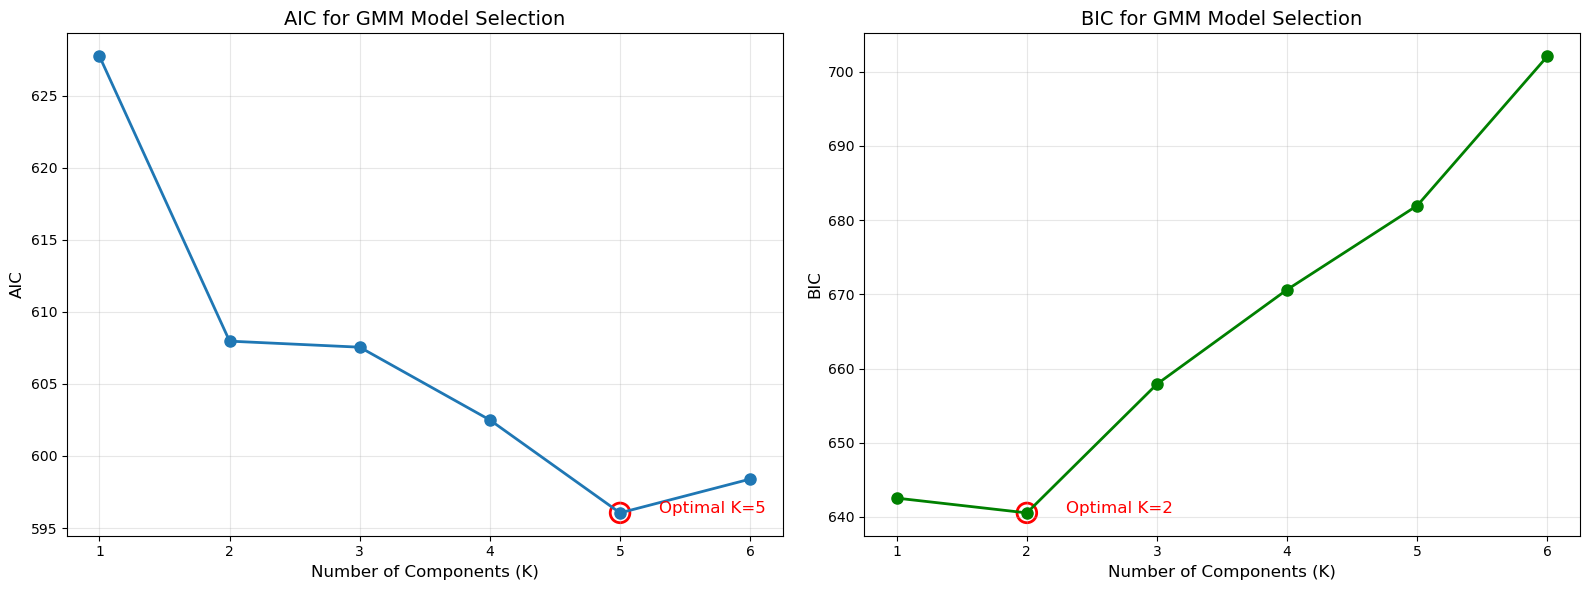

Based on AIC, the optimal number of components is: 5
Based on BIC, the optimal number of components is: 2


In [49]:
def compute_aic_bic(log_likelihood, n_samples, n_components, n_dimensions):
    """
    Compute AIC and BIC for model selection
    
    Parameters:
    -----------
    log_likelihood : float
        Log-likelihood of the model
    n_samples : int
        Number of data points
    n_components : int
        Number of Gaussian components
    n_dimensions : int
        Number of dimensions
    
    Returns:
    --------
    aic : float
        Akaike Information Criterion
    bic : float
        Bayesian Information Criterion
    """
    # Number of free parameters
    # For a GMM with K components in D dimensions:
    # - K-1 parameters for mixture weights (they sum to 1)
    # - K*D parameters for means
    # - K*D*(D+1)/2 parameters for covariance matrices (symmetric)
    n_parameters = (n_components - 1) + (n_components * n_dimensions) + \
                   (n_components * n_dimensions * (n_dimensions + 1) // 2)
    
    # Compute AIC and BIC as defined in the lecture notes
    aic = -2 * log_likelihood + 2 * n_parameters
    bic = -2 * log_likelihood + n_parameters * np.log(n_samples)
    
    return aic, bic

def gmm_model_selection(X, k_range=range(1, 10), init_method='kmeans++', random_state=42):
    """
    Fit GMMs with different numbers of components and compute AIC and BIC
    
    Parameters:
    -----------
    X : array, shape (n_samples, n_dimensions)
        The input data
    k_range : iterable
        Range of k values to try
    init_method : str
        Initialization method
    random_state : int or None
        Random seed for reproducibility
    
    Returns:
    --------
    results : dict
        Dictionary containing log-likelihoods, AICs, and BICs
    """
    n_samples, n_dimensions = X.shape
    
    results = {
        'k': list(k_range),
        'log_likelihood': [],
        'aic': [],
        'bic': [],
        'n_parameters': []
    }
    
    for k in k_range:
        print(f"Fitting GMM with {k} components...")
        # Fit GMM with k components
        weights, means, covariances, _, log_likelihood, n_iter, _ = fit_gmm(
            X, k, init_method=init_method, random_state=random_state)
        
        # Compute AIC and BIC
        aic, bic = compute_aic_bic(log_likelihood, n_samples, k, n_dimensions)
        
        # Calculate number of parameters
        n_parameters = (k - 1) + (k * n_dimensions) + (k * n_dimensions * (n_dimensions + 1) // 2)
        
        # Store results
        results['log_likelihood'].append(log_likelihood)
        results['aic'].append(aic)
        results['bic'].append(bic)
        results['n_parameters'].append(n_parameters)
        
        print(f"  Log-likelihood: {log_likelihood:.2f}")
        print(f"  Parameters: {n_parameters}")
        print(f"  AIC: {aic:.2f}")
        print(f"  BIC: {bic:.2f}")
    
    return results

# Run model selection for a range of components
k_range = range(1, 7)  # Testing k from 1 to 6
results = gmm_model_selection(X_std, k_range=k_range)

# Plot AIC and BIC
plt.figure(figsize=(16, 6))

# Plot AIC
plt.subplot(1, 2, 1)
plt.plot(results['k'], results['aic'], 'o-', linewidth=2, markersize=8)
plt.xlabel('Number of Components (K)', fontsize=12)
plt.ylabel('AIC', fontsize=12)
plt.title('AIC for GMM Model Selection', fontsize=14)
plt.xticks(k_range)
plt.grid(True, alpha=0.3)

# Highlight the minimum AIC
min_aic_idx = np.argmin(results['aic'])
plt.scatter(results['k'][min_aic_idx], results['aic'][min_aic_idx], 
           s=200, facecolors='none', edgecolors='r', linewidth=2)
plt.annotate(f'Optimal K={results["k"][min_aic_idx]}',
             xy=(results['k'][min_aic_idx], results['aic'][min_aic_idx]),
             xytext=(results['k'][min_aic_idx]+0.3, results['aic'][min_aic_idx]),
             fontsize=12, color='r')

# Plot BIC
plt.subplot(1, 2, 2)
plt.plot(results['k'], results['bic'], 'o-', linewidth=2, markersize=8, color='green')
plt.xlabel('Number of Components (K)', fontsize=12)
plt.ylabel('BIC', fontsize=12)
plt.title('BIC for GMM Model Selection', fontsize=14)
plt.xticks(k_range)
plt.grid(True, alpha=0.3)

# Highlight the minimum BIC
min_bic_idx = np.argmin(results['bic'])
plt.scatter(results['k'][min_bic_idx], results['bic'][min_bic_idx], 
           s=200, facecolors='none', edgecolors='r', linewidth=2)
plt.annotate(f'Optimal K={results["k"][min_bic_idx]}',
             xy=(results['k'][min_bic_idx], results['bic'][min_bic_idx]),
             xytext=(results['k'][min_bic_idx]+0.3, results['bic'][min_bic_idx]),
             fontsize=12, color='r')

plt.tight_layout()
plt.show()

print(f"Based on AIC, the optimal number of components is: {results['k'][min_aic_idx]}")
print(f"Based on BIC, the optimal number of components is: {results['k'][min_bic_idx]}")

### Model Selection for GMM: Comparing AIC and BIC
 
Our GMM analysis revealed that the AIC suggests 5 components as optimal, while the BIC suggests only 2 components. This difference aligns perfectly with what we discussed in the lecture notes about these information criteria.
 
The Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC) represent different philosophical approaches to model selection:
 
- **AIC** focuses on finding the model that will make the best predictions on new data. It has a smaller penalty for model complexity (2P), making it more likely to select models with more components that capture subtle structures in the data.
 
- **BIC** aims to identify the "true" model that generated the data. Its stronger penalty for complexity (P ln(N)) makes it more conservative in adding parameters, typically selecting simpler models.
 
As noted in our lecture, "BIC tends to select simpler models than AIC, especially for large sample sizes. BIC's stronger penalty for complexity makes it more conservative in adding parameters."
 
Deciding between 2 versus 5 components presents a challenge, primarily due to the limited data available. However, if we take the optimistic route and accept the AIC's suggestion of 5 components, we can explore richer astrophysical implications.
 
### Astrophysical Implications
 
The multimodal distribution we observed in the Sculptor dwarf galaxy's chemical abundances has profound astrophysical implications, as detailed in Ting & Ji's paper "Quantifying Bursty Star Formation in Dwarf Galaxies" (2025):

1. **Evidence for Episodic Star Formation**: The discontinuous tracks in the [Mg/Fe]-[Fe/H] plane suggest that Sculptor experienced multiple distinct bursts of star formation separated by quiescent periods of approximately 300 Myr.
 
2. **Enrichment Mechanism**: During quiescent periods, Type Ia supernovae continued to enrich the interstellar medium with iron but produced little magnesium. When star formation resumed, new stars formed with enhanced iron but depleted [Mg/Fe], creating the observed gaps in chemical abundance.
 
3. **High Time Resolution**: This chemical analysis provides refined time resolution for star formation histories in early dwarf galaxies, capturing features that traditional color-magnitude diagram analyses cannot resolve.
 
4. **Connections to High-Redshift Observations**: The episodic star formation pattern in Sculptor aligns with JWST observations of "miniquenching" in higher-mass dwarf galaxies at high redshift, extending those conclusions to galaxies much fainter than can be directly observed at those distances.

### What We've Learned

In this tutorial, we've built both K-means and Gaussian Mixture Models from scratch and applied them to real astronomical data. The key takeaways include:

1. **Clustering Reveals Structure**: Unsupervised clustering algorithms can identify meaningful patterns in chemical abundance data that inform our understanding of galaxy formation and evolution.

2. **Model Selection is Critical**: Different information criteria (AIC vs. BIC) prioritize different aspects of model performance, leading to different optimal solutions. The choice depends on whether we prioritize predictive power or model simplicity.

3. **GMMs Offer Advantages**: While K-means provides a simple approach to clustering, GMMs offer greater flexibility by allowing for:
   - Clusters of different shapes and sizes
   - Probabilistic (soft) assignments
   - Uncertainty quantification in cluster membership

4. **Astrophysical Significance**: The multimodal structure we observed in Sculptor's chemical abundances provides evidence for episodic star formation, allowing us to infer its formation history with unprecedented temporal resolution.

By understanding these clustering techniques, astronomers can extract more information from chemical abundance data, effectively turning elements into timekeepers that reveal the detailed history of galaxy formation.